### Задание выполняли

### Микишева М.А. - гр.Б03-213с
### Берёзкин Ф.П. - гр.Б03-212и

## Распределение задач:

Задание № 1 Добавьте генератор суммаризации для модели, приведет демонстрацию результата для 5 примеров из теста и 5 собственных примеров. - Микишева М. А.

Задание № 2 Добавьте оценку для модели с помощью ROUGE metric - Берёзкин Ф.П

Задание № 3 Добавьте визуализацию механизма attention после обучения модели на конкретном примере (не менее 3 примеров). - Берёзкин Ф.П

Задание № 4 Сделайте общими матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера). - Берёзкин Ф.П

Задание № 5 Замените функцию ошибки на LabelSmoothing. - Микишева М. А.

Задание № 6 Добавьте предодученные эмбединги при обучении модели, покажите разницу в метрике до и после. -  Микишева М. А.

In [ ]:
!pip install torchtext==0.6.0 sacremoses spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 123.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import re
import dill
import gzip
import heapq
import random
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import sentencepiece as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext.data import Field, Example, Dataset, BucketIterator
from collections import Counter
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords

%matplotlib inline

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    DEVICE = torch.device('cuda')
    print(f"Running on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    DEVICE = torch.device('cpu')
    print("No GPU found, running on CPU")

np.random.seed(42)

Running on GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/коалиция_ниггавуманов/"

### Датасет

In [ ]:
!wget -O news.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
!unzip news.zip

Archive:  news.zip
replace news.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!shuf -n 10 news.csv

### NLTK стоп-слова

In [ ]:
nltk.download('stopwords')
ru_stopwords = set(stopwords.words("russian"))

# Abstactive Summarization

Задача - по тексту сгенерировать выдержку из него.

Например, попробуем по новостям генерировать заголовки:

In [ ]:
!shuf -n 10 news.csv

Токенизируем их. Будем использовать единый словарь для текста и заголовков.

### Токенизатор

In [ ]:
nlp = spacy.load("ru_core_news_sm")
ru_stopwords = set(stopwords.words("russian"))

def spacy_tokenize(text):
    return [
        token.text.lower()
        for token in nlp(text)
        if not token.is_space and not token.is_punct
    ]

In [ ]:
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

word_field = Field(
    tokenize=spacy_tokenize,
    init_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
    lower=False,
    include_lengths=True
)
fields = [("source", word_field), ("target", word_field)]

### Генерация examples

In [ ]:
examples_path = save_path + "/dataset_examples_пупу.pkl"

In [ ]:
if os.path.exists(examples_path):
    print("загружаем examples из файла...")
    with open(examples_path, "rb") as f:
        examples = dill.load(f)
else:
    print("генерация examples с нуля. (~1 час пупупу...)")

    data = pd.read_csv("news.csv", delimiter=",", encoding="utf-8-sig")
    examples = []
    for _, row in tqdm(data.iterrows(), total=len(data)):
        source_text = word_field.preprocess(row.text)
        target_text = word_field.preprocess(row.title)
        examples.append(Example.fromlist([source_text, target_text], fields))

    with open(examples_path, "wb") as f:
        dill.dump(examples, f)
    print("examples в", examples_path)

Построим датасеты:

In [ ]:
vec_gz_path = save_path + 'cc.ru.300.vec.gz'
vec_txt_path = save_path + 'cc.ru.300.vec'

if not os.path.exists(vec_txt_path):
    with gzip.open(vec_gz_path, 'rt', encoding='utf-8') as f_in:
        with open(vec_txt_path, 'w', encoding='utf-8') as f_out:
            for line in f_in:
                f_out.write(line)
else:
    print("распаковано:", vec_txt_path)

распаковано: /content/cc.ru.300.vec


In [ ]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print("Train size =", len(train_dataset))
print("Test size =", len(test_dataset))

Train size = 63136
Test size = 11142


### Построение словаря с учётом стоп-слов

In [ ]:
from collections import Counter
token_counter = Counter()
for ex in train_dataset.examples:
    token_counter.update(ex.source)

for stopword in ru_stopwords:
    if stopword in token_counter:

        token_counter[stopword] = max(1, token_counter[stopword] // 10)

In [ ]:
from torchtext.vocab import Vocab
word_field.vocab = Vocab(token_counter, specials=[UNK_TOKEN, PAD_TOKEN, BOS_TOKEN, EOS_TOKEN], min_freq=10)

### Подгрузка русских FastText эмбеддингов

In [ ]:
fasttext_path = save_path + "cc.ru.300.vec"
vectors = {}

In [ ]:
with open(fasttext_path, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)

        norm = np.linalg.norm(vector)
        if norm > 0:
            vector /= norm

        vectors[word] = vector

### Формируем embedding matrix


In [ ]:
embedding_dim = 300
embedding_matrix = np.random.normal(scale=0.01, size=(len(word_field.vocab), embedding_dim))

In [ ]:
for i in range(len(embedding_matrix)):
    if word_field.vocab.itos[i] not in vectors:
        norm = np.linalg.norm(embedding_matrix[i])
        if norm > 0:
            embedding_matrix[i] /= norm

In [ ]:
for i, token in enumerate(word_field.vocab.itos):
    if token in vectors:
        embedding_matrix[i] = vectors[token]

pretrained_embeddings = torch.tensor(embedding_matrix, dtype=torch.float)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset),
    batch_sizes=(16, 32),
    shuffle=True,
    device=DEVICE,
    sort=False,
    sort_key=lambda x: len(x.source),
)

#### Статистика

In [ ]:
print("Размер словаря (vocab size):", len(word_field.vocab))
print("Размер embedding_matrix:", embedding_matrix.shape)
print("Размер pretrained_embeddings:", pretrained_embeddings.shape)

In [ ]:

unk_idx = word_field.vocab.stoi[UNK_TOKEN]
print(f"Слов в UNK: {sum(1 for word in word_field.vocab.itos if word_field.vocab.stoi[word] == unk_idx)}")

Слов в UNK: 1


#### Покрытие слов фасттекстом

In [ ]:
found = sum(1 for token in word_field.vocab.itos if token in vectors)
print(f"Найдено в fastText векторов: {found}/{len(word_field.vocab)}")
print(f"Процент покрытия: {found / len(word_field.vocab) * 100:.2f}%")

Найдено в fastText векторов: 37777/40877
Процент покрытия: 92.42%


#### Примеры эмббедингов

In [ ]:
for word in ['<unk>', 'москва', 'президент', 'экономика']:
    idx = word_field.vocab.stoi.get(word)
    if idx is not None:
        print(f"Слово '{word}' индекс {idx}, эмбеддинг: {pretrained_embeddings[idx][:5]}")
    else:
        print(f"Слово '{word}' не найдено в словаре.")

Слово '<unk>' индекс 0, эмбеддинг: tensor([-0.0025, -0.0968, -0.0303, -0.0351, -0.0216])
Слово 'москва' индекс 642, эмбеддинг: tensor([ 0.1637, -0.0695,  0.0518, -0.0765,  0.0932])
Слово 'президент' индекс 107, эмбеддинг: tensor([ 0.1002, -0.0172,  0.0429, -0.0020, -0.0215])
Слово 'экономика' индекс 10679, эмбеддинг: tensor([ 0.0380, -0.1065, -0.0602,  0.0646, -0.0701])


In [ ]:
print("Embedding stats:")
print(f"Mean: {pretrained_embeddings.mean().item():.4f}")
print(f"Std: {pretrained_embeddings.std().item():.4f}")
print(f"NaN values: {torch.isnan(pretrained_embeddings).sum().item()}")

Embedding stats:
Mean: 0.0007
Std: 0.0577
NaN values: 0


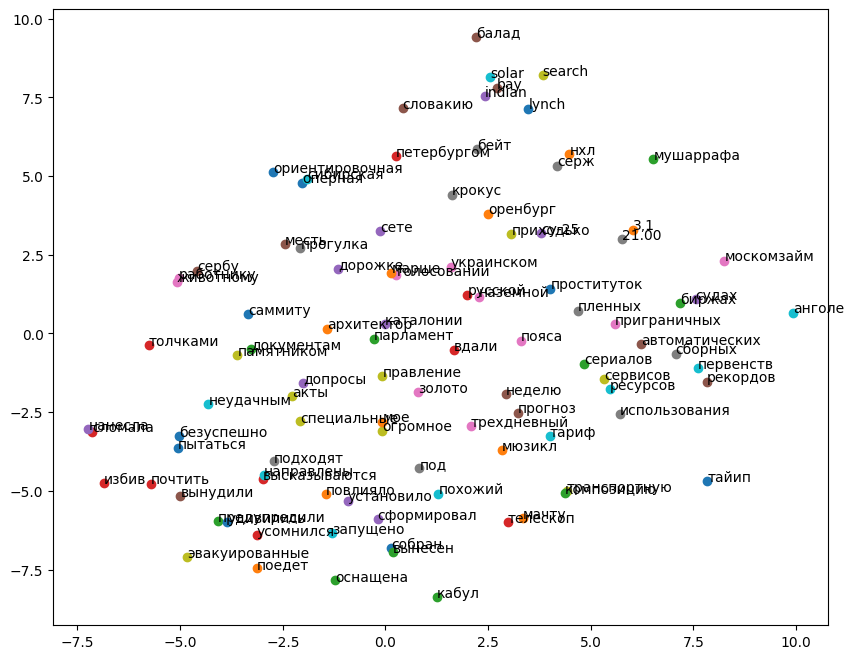

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

sample_words = np.random.choice(word_field.vocab.itos, 100, replace=False)
sample_embeddings = np.array([embedding_matrix[word_field.vocab.stoi[word]] for word in sample_words])

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(sample_embeddings)

plt.figure(figsize=(10, 8))
for i, word in enumerate(sample_words):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


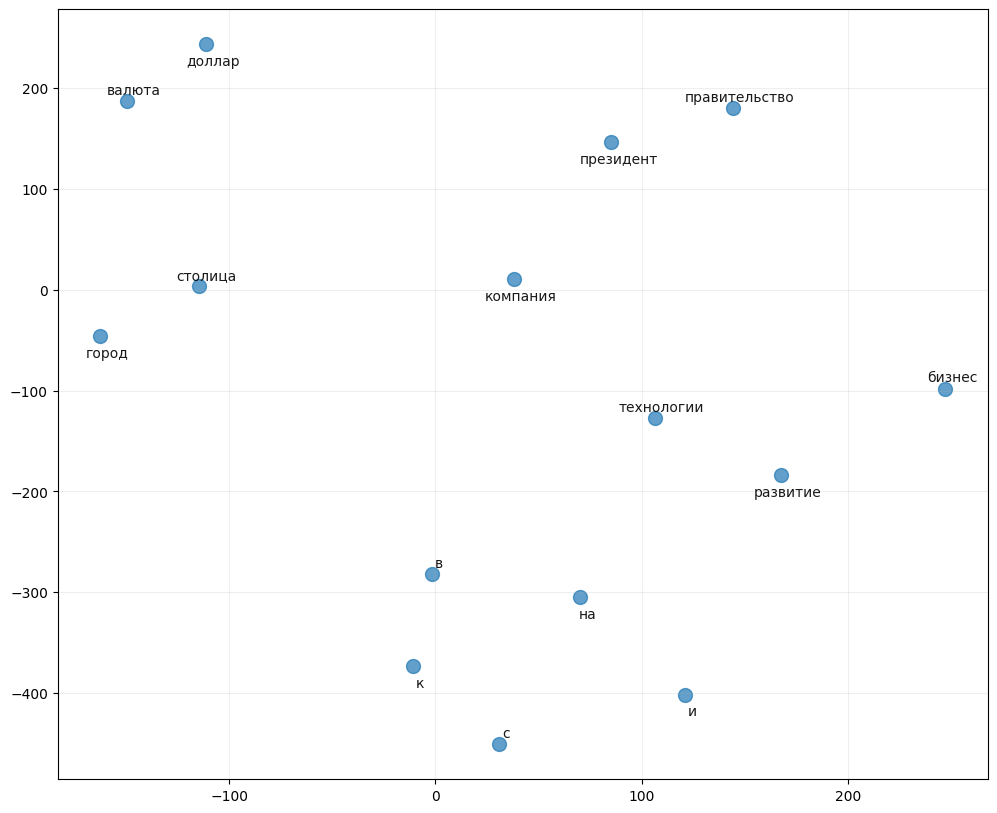

In [ ]:
from sklearn.preprocessing import MinMaxScaler

words = ["Москва", "город", "столица", "Россия",
         "президент", "правительство", "доллар", "валюта",
         "компания", "бизнес", "развитие", "технологии",
         "и", "в", "на", "с", "к"]  # + служебные слова

words = [w for w in words if w in word_field.vocab.stoi]

embeddings = pretrained_embeddings[[word_field.vocab.stoi[w] for w in words]].numpy()
embeddings = MinMaxScaler().fit_transform(embeddings)

tsne = TSNE(
    n_components=2,
    perplexity=min(5, len(words)-1),
    early_exaggeration=12,
    learning_rate=200,
    n_iter=5000,
    random_state=42,
    metric='cosine'
)

result = tsne.fit_transform(embeddings)
plt.figure(figsize=(12, 10))
plt.scatter(result[:, 0], result[:, 1], s=100, alpha=0.7)

for i, word in enumerate(words):
    x, y = result[i]
    plt.annotate(
        word,
        (x, y),
        textcoords="offset points",
        xytext=(5, 5 if i%2 else -15),
        ha='center',
        fontsize=10,
        alpha=0.9
    )

plt.grid(alpha=0.2)
plt.show()

In [ ]:
test_words = set(word for ex in test_dataset.examples for word in ex.source)
unk_in_test = test_words - set(word_field.vocab.itos)
print(f"UNK в тестовых данных: {len(unk_in_test)} слов")

UNK в тестовых данных: 64795 слов


### Топ и хвост словаря

Выведем топ 50 самых частых слов

In [ ]:
vocab_words_sorted = sorted(word_field.vocab.freqs.items(), key=lambda x: -x[1])
print("\nТоп 50 слов:")
for i, (word, freq) in enumerate(vocab_words_sorted[:50]):
    print(f"{i+1}: {word} — {freq}")


Топ 50 слов:
1: сообщает — 37258
2: в — 29301
3: года — 15873
4: человек — 12791
5: также — 12644
6: россии — 12490
7: время — 12449
8: на — 12362
9: новости — 12198
10: риа — 11822
11: результате — 11546
12: около — 10257
13: и — 10074
14: данным — 10063
15: словам — 8250
16: ссылкой — 7842
17: году — 7658
18: интерфакс — 7631
19: сша — 7532
20: передает — 7384
21: это — 7323
22: агентство — 7262
23: пока — 7256
24: который — 7193
25: по — 7128
26: пресс — 6891
27: сообщается — 6666
28: произошел — 6535
29: однако — 6471
30: тысяч — 6337
31: области — 6134
32: ранее — 6105
33: города — 6031
34: погибли — 5778
35: заявил — 5701
36: происшествия — 5519
37: сообщили — 5460
38: несколько — 5440
39: долларов — 5405
40: москвы — 5331
41: с — 5323
42: которые — 5214
43: место — 5122
44: районе — 5118
45: сообщил — 5044
46: информации — 4925
47: рф — 4835
48: москве — 4632
49: получили — 4534
50: времени — 4514


Топ редких слов(50 шт)

In [ ]:
print("\nПоследние 50 слов:")
for i, (word, freq) in enumerate(vocab_words_sorted[-50:]):
    print(f"{len(vocab_words_sorted)-50+i+1}: {word} — {freq}")


Последние 50 слов:
256561: позировавшая — 1
256562: чулках — 1
256563: подвязками — 1
256564: блудницей — 1
256565: раав — 1
256566: hовосмоленской — 1
256567: агентство"интерфакс — 1
256568: хадзиева — 1
256569: таллиннская — 1
256570: тулатайп — 1
256571: шипела — 1
256572: таланг — 1
256573: оонами — 1
256574: савагири — 1
256575: курама — 1
256576: медат — 1
256577: авдюкова — 1
256578: порядкового — 1
256579: прикинулись — 1
256580: палеевой — 1
256581: райдера — 1
256582: бросании — 1
256583: игральной — 1
256584: контест — 1
256585: удостоившихся — 1
256586: обаятельной — 1
256587: munn — 1
256588: заберем — 1
256589: ищете — 1
256590: вэньчан — 1
256591: fourniret — 1
256592: тили — 1
256593: thily — 1
256594: един — 1
256595: описаниях — 1
256596: шенксвилле — 1
256597: дарваз — 1
256598: летти — 1
256599: рожериу — 1
256600: бомбардирскими — 1
256601: подвигами — 1
256602: сисиньо — 1
256603: луизао — 1
256604: эдмилсон — 1
256605: пернамбукану — 1
256606: рикардиньо — 1
256

 Проверим наличие <unk> токенов при токенизации нормальных текстов

In [ ]:
sample_text = "посол россии пересек границу после эвакуации"
tokens = [word_field.init_token] + word_field.tokenize(sample_text.lower()) + [word_field.eos_token]
indexed_tokens = [
    word_field.vocab.stoi.get(token, word_field.vocab.stoi[word_field.unk_token])
    for token in tokens
]
unk_count = sum(1 for idx in indexed_tokens if idx == word_field.vocab.stoi[word_field.unk_token])
print(f"\nВсего токенов: {len(tokens)}")
print(f"Из них UNK токенов: {unk_count}")


Всего токенов: 8
Из них UNK токенов: 0


In [ ]:
def analyze_vocabulary(vocab, data=None, max_words_to_print=20):
    """
    Анализирует словарь и предоставляет информацию о его составе и качестве.

    Args:
        vocab: Объект словаря (например, word_field.vocab из torchtext).
        data:  Список или итератор с текстовыми данными (для оценки покрытия словаря).  Если None, оценка покрытия не производится.
        max_words_to_print: Максимальное количество самых частых и самых редких слов для отображения.

    Returns:
        None.  Функция печатает результаты анализа в консоль.
    """

    vocab_size = len(vocab)
    unk_index = vocab.stoi.get("<unk>")
    pad_index = vocab.stoi.get("<pad>")
    bos_index = vocab.stoi.get("<s>")
    eos_index = vocab.stoi.get("</s>")

    print(f"Размер словаря: {vocab_size}")

    print("\nПроверка специальных токенов:")
    if "<unk>" in vocab.stoi:
        print(f"  Токен <unk> найден в словаре, индекс: {unk_index}")
    else:
        print("  Токен <unk> НЕ найден в словаре.")
    if "<pad>" in vocab.stoi:
        print(f"  Токен <pad> найден в словаре, индекс: {pad_index}")
    else:
        print("  Токен <pad> НЕ найден в словаре.")
    if "<s>" in vocab.stoi:
        print(f"  Токен <s> (BOS) найден в словаре, индекс: {bos_index}")
    else:
        print("  Токен <s> (BOS) НЕ найден в словаре.")
    if "</s>" in vocab.stoi:
        print(f"  Токен </s> (EOS) найден в словаре, индекс: {eos_index}")
    else:
        print("  Токен </s> (EOS) НЕ найден в словаре.")

    if hasattr(vocab, 'freqs'):
        print("\nАнализ частотности слов:")
        vocab_words_sorted = sorted(vocab.freqs.items(), key=lambda x: -x[1])

        print(f"  {max_words_to_print} самых частых слов:")
        for i, (word, freq) in enumerate(vocab_words_sorted[:max_words_to_print]):
            print(f"    {i+1}: {word} — {freq}")

        print(f"\n  {max_words_to_print} самых редких слов:")
        for i, (word, freq) in enumerate(vocab_words_sorted[-max_words_to_print:]):
            print(f"    {vocab_size-max_words_to_print+i+1}: {word} — {freq}")
    else:
        print("\nИнформация о частотах слов недоступна в словаре.")

    if data:
        print("\nОценка покрытия словаря:")
        unk_count = 0
        total_tokens = 0
        for text in data:
            for token in text:
                total_tokens += 1
                if vocab.stoi.get(token, unk_index) == unk_index:
                    unk_count += 1

        unk_percentage = (unk_count / total_tokens) * 100
        print(f"  Всего токенов в данных: {total_tokens}")
        print(f"  Количество токенов <unk>: {unk_count}")
        print(f"  Процент токенов <unk>: {unk_percentage:.2f}%")

        if hasattr(vocab, 'freqs'):
            frequencies = [freq for word, freq in vocab_words_sorted]
            plt.figure(figsize=(10, 5))
            plt.plot(frequencies)
            plt.xlabel("Ранг слова")
            plt.ylabel("Частота")
            plt.title("Распределение частот слов")
            plt.yscale('log')
            plt.show()

        print("\nКритерии 'хорошести' словаря (ориентировочные):")
        if vocab_size < 1000:
            print("  Словарь слишком маленький. Рассмотрите увеличение min_freq или использование большего объема данных.")
        elif vocab_size > 50000:
            print("  Словарь может быть слишком большим.  Рассмотрите уменьшение объема данных, увеличение min_freq или использование subword токенизации.")

        if unk_percentage > 5.0:
            print("  Процент неизвестных слов слишком высок.  Рассмотрите уменьшение min_freq, использование большего объема данных или subword токенизацию.")
        else:
            print("  Процент неизвестных слов находится в приемлемом диапазоне.")
    else:
        print("\nДанные для оценки покрытия словаря не предоставлены.")

Размер словаря: 40877

Проверка специальных токенов:
  Токен <unk> найден в словаре, индекс: 0
  Токен <pad> найден в словаре, индекс: 1
  Токен <s> (BOS) найден в словаре, индекс: 2
  Токен </s> (EOS) найден в словаре, индекс: 3

Анализ частотности слов:
  20 самых частых слов:
    1: сообщает — 37258
    2: в — 29301
    3: года — 15873
    4: человек — 12791
    5: также — 12644
    6: россии — 12490
    7: время — 12449
    8: на — 12362
    9: новости — 12198
    10: риа — 11822
    11: результате — 11546
    12: около — 10257
    13: и — 10074
    14: данным — 10063
    15: словам — 8250
    16: ссылкой — 7842
    17: году — 7658
    18: интерфакс — 7631
    19: сша — 7532
    20: передает — 7384

  20 самых редких слов:
    40858: fourniret — 1
    40859: тили — 1
    40860: thily — 1
    40861: един — 1
    40862: описаниях — 1
    40863: шенксвилле — 1
    40864: дарваз — 1
    40865: летти — 1
    40866: рожериу — 1
    40867: бомбардирскими — 1
    40868: подвигами — 1
    4

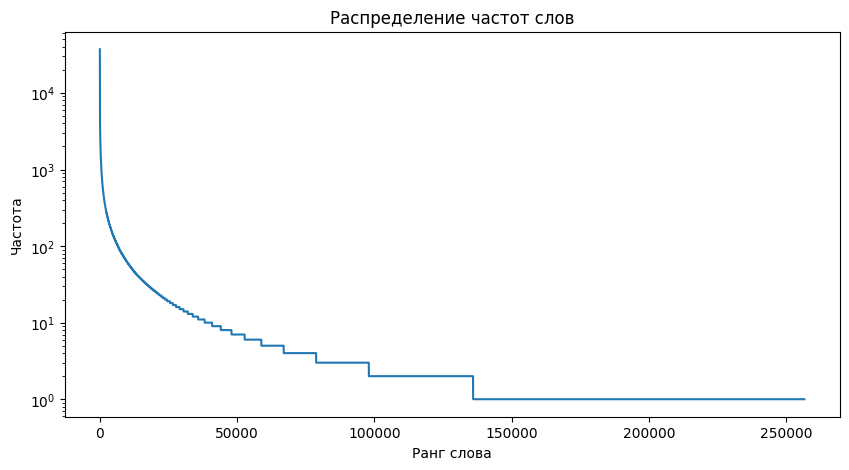


Критерии 'хорошести' словаря (ориентировочные):
  Процент неизвестных слов слишком высок.  Рассмотрите уменьшение min_freq, использование большего объема данных или subword токенизацию.


In [ ]:
    analyze_vocabulary(word_field.vocab, data=[ex.source for ex in train_dataset.examples])

#### Сохрнение словаря (если новый!!/)

In [ ]:
vocab_save_path = save_path + "vocab_nlp_pupupu.pt"
word_field_save_path = save_path + "word_field_nlp_pupupu.pt"


torch.save(word_field.vocab, vocab_save_path, pickle_module=dill)

torch.save(word_field, word_field_save_path, pickle_module=dill)

#### Подгрузка словаря

In [ ]:
word_field = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
print("word_field загружен целиком")

vocab = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)
word_field.vocab = vocab
print("vocab подставлен в word_field")

In [ ]:
#word_field = torch.load(save_path+"word_field_nlp1.pt", pickle_module=dill)
#vocab = torch.load(save_path+"vocab_nlp1.pt", pickle_module=dill)
#word_field.vocab = vocab

## Seq2seq for Abstractive Summarization

Вообще задача не сильно отличается от машинного перевода:

![](https://image.ibb.co/jAf3S0/2018-11-20-9-42-17.png)
*From [Get To The Point: Summarization with Pointer-Generator Networks](https://arxiv.org/pdf/1704.04368.pdf)*

Тут на каждом шаге декодер подглядывает на все токены - точнее, их эмбеддинги после BiRNN.

Возникает вопрос - а зачем вообще RNN, если потом все равно будем смотреть на всё.

# Transformer

Из этой идеи - отказ от RNN - и получился Transformer.

![](https://hsto.org/webt/59/f0/44/59f04410c0e56192990801.png)  
*From Attention is all you need*

Как в случае с RNN мы на каждом шаге применяем одну и ту же операцию (ячейку LSTM) к текущему входу, так и здесь - только теперь связей между timestamp'ами нет и можно обрабатывать их почти параллельно.

*Код дальше очень сильно опирается на шикарную статью [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html).*

## Encoder

Начнем с энкодера:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

Он представляет из себя последовательность одинаковых блоков с self-attention + полносвязными слоями.

Можно представить, что это - ячейка LSTM: она тоже применяется к каждому входу с одинаковыми весами. Разница основная в отсутствии рекуррентных связей: за счет этого энкодер может применяться одновременно ко всем входам батча.

### Positional Encoding

Нужно как-то кодировать информацию о том, в каком месте в предложении стоит токен. Авторы предложили делать так:
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$
$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$

где $(pos, i)$ - позиция в предложении и индекс в скрытом векторе размерности до $d_{model}$.

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

В итоге эмбеддинги токена получается как сумма обычного эмбеддинга и эмбеддинга позиции:  
![](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

### Residual Connection

Разберем блок энкодера - повторяющейся N раз комбинации операций на первом рисунке.

Самое простое здесь - residual connection. Вместо к выходу произвольной функции $F$ прибавляется её вход
$$y = F(x) \quad \to \quad y = F(x) + x$$

Идея в том, что обычные сети сложно делать слишком глубокими - градиенты затухают. А через этот residual вход $x$ градиентам течь ничего не стоит. В итоге в картинках благодаря таким блокам получилось настакать дофига слоев и улучшить качество (см. ResNet).

Ничего не мешает нам поступить также.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))

### Layer Norm

Дополнительно применяется нормализация LayerNorm.

**Batch normalization**  
Мы вообще не разбирали, но BatchNorm работает так:
$$\mu_j = \frac{1}{m}\sum_{i=1}^{m}x_{ij} \\    \sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m}(x_{ij} - \mu_j)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

На каждом батче эти $\mu$ и $\sigma$ пересчитываются, обновляя статистики. На инференсе используются накопленные статистики.

Основной его недостаток - он плохо работает с рекуррентными сетями. Чтобы побороть это придумали:

**Layer normalization**  
А сейчас мы будем пользоваться немного другими формулами:
$$\mu_i = \frac{1}{m}\sum_{j=1}^{m}x_{ij} \\    \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m}(x_{ij} - \mu_i)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

Разницу с ходу не видно, но она есть:
![](https://image.ibb.co/hjtuX0/layernorm.png)  
*From [Weight Normalization and Layer Normalization Explained ](http://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/)*

Если в BatchNorm статистики считаются для каждой фичи усреднением по батчу, то теперь - для каждого входа усредением по фичам.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta

### Attention

Весь Transformer опирается на идею self-attention. Выглядит это так:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Эмбеддинг слова *it* строится как комбинация всех эмбеддингов предложения.

В статье придумали делать такой аттеншен:

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Это примерно как dot-attention на прошлом занятии: запрос (**Q**uery) умножается на ключи (**K**ey) скалярно, затем берется софтмакс - получаются оценки того, насколько интересны разные таймстемпы из значений (**V**alue).

Например, $\mathrm{emb}(\text{it}) = \mathrm{Attention}(\text{it}, \ldots\text{because it was too tired}, \ldots\text{because it was too tired})$.

Только теперь ещё с параметром $\frac{1}{\sqrt{d_k}}$, где $d_k$ - это размерность ключа. Утверждается, это работает лучше при больших размерностях ключа $d_k$.

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention

![](https://hsto.org/webt/59/f0/44/59f0440f1109b864893781.png)

Важная идея, почему attention (и, главное, self-attention) заработал - использование нескольких голов (multi-head).

Вообще, когда мы делаем attention - мы определяем похожесть ключа и запроса. Многоголовость помогает (должна) определять эту похожесть по разным критериям - синтаксически, семантически и т.д.

Например, на картинке используется две головы и одна голова смотрит на *the animal* при генерации *it*, вторая - на *tired*:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Применяется это таким образом:

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$
    
где $W^Q_i \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W^V_i \in \mathbb{R}^{d_{model} \times d_v}, W^O \in \mathbb{R}^{hd_v \times d_{model}}$.

В оригинальной статье использовали $h=8$, $d_k=d_v=d_{\text{model}}/h=64$.

Процесс применения такой:
![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)  
*From Illustrated Transformer*

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x

### Position-wise Feed-Forward Networks

Линейный блок в энкодере выглядит так:
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))

### Encoder block

Соберем все в блок:

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

Предполагается, что использование

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False, pretrained_embeddings = None, shared_embeddings = None):
        super().__init__()

        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding(vocab_size, 300)

            self.embedding_layer.weight.data.copy_(pretrained_embeddings)
            self.embedding_layer.weight.requires_grad = True

            #  проекция из 300 в d_model
            self.embedding_proj = nn.Linear(300, d_model)

            self._pos_enc = PositionalEncoding(d_model, dropout_rate)
            self._emb = nn.Sequential(
                    self.embedding_layer,
                    self.embedding_proj,
                    self._pos_enc
             )
        elif shared_embeddings is None:
            self._emb = nn.Sequential(
                nn.Embedding(vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
        else:
            self._emb = shared_embeddings

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.attn_probs = []

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)
        self.attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, mask)
            if self.save_probs:
                self.attn_probs.append(block._self_attn._attn_probs)

        return self._norm(inputs)

In [ ]:
# Вот это

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, embeddings, save_probs = False):
        super().__init__()

        self._emb = embeddings

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.attn_probs = []

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)
        self.attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, mask)
            if self.save_probs:
                self.attn_probs.append(block._self_attn._attn_probs)

        return self._norm(inputs)

## Decoder

![](https://hsto.org/webt/59/f0/44/59f0440f7d88f805415140.png)

Блок декодера (серая часть) состоит уже из трех частей:
1. Сперва - тот же self-attention, что и в энкодере
2. Затем - стандартный attention на выходы из энкодера + текущее состояние декодера (такой же был в seq2seq with attention)
3. Наконец - feed-forward блок

Всё это, конечно, с residual связями.

In [ ]:

class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False, pretrained_embeddings = None, shared_embeddings = None):
        super().__init__()
        self._out_layer = nn.Linear(d_model, vocab_size)

        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding(vocab_size, 300)

            self.embedding_layer.weight.data.copy_(pretrained_embeddings)
            self.embedding_layer.weight.requires_grad = True

            #  проекция из 300 в d_model
            self.embedding_proj = nn.Linear(300, d_model)

            self._pos_enc = PositionalEncoding(d_model, dropout_rate)
            self._emb = nn.Sequential(
                    self.embedding_layer,
                    self.embedding_proj,
                    self._pos_enc
             )
        elif shared_embeddings is None:
            self._emb = nn.Sequential(
                nn.Embedding(vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
        else:
            self._emb = shared_embeddings
            self._out_layer.weight = self._emb[0].weight  # Весовая привязка



        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)


        self.save_probs = save_probs
        self.self_attn_probs = []
        self.enc_attn_probs = []

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        self.self_attn_probs = []
        self.enc_attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            if self.save_probs:
                self.self_attn_probs.append(block._self_attn._attn_probs)
                self.enc_attn_probs.append(block._encoder_attn._attn_probs)
        return self._out_layer(self._norm(inputs))

In [ ]:
#Вот это

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, embeddings, out_layer, save_probs = False):
        super().__init__()
        self._out_layer = out_layer
        self._emb = embeddings

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)


        self.save_probs = save_probs
        self.self_attn_probs = []
        self.enc_attn_probs = []

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        self.self_attn_probs = []
        self.enc_attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            if self.save_probs:
                self.self_attn_probs.append(block._self_attn._attn_probs)
                self.enc_attn_probs.append(block._encoder_attn._attn_probs)
        return self._out_layer(self._norm(inputs))

В декодере нужно аттентиться только на предыдущие токены - сгенерируем маску для этого:

In [ ]:
def subsequent_mask(size):
    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].cpu().numpy())

## Полная модель

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1, save_probs = False, use_shared_emb = False, pretrained_embeddings=None):
        super(EncoderDecoder, self).__init__()

        shared_embeddings = None
        if use_shared_emb:
            assert source_vocab_size == target_vocab_size, "Vocab sizes must match for shared embeddings"
            self._emb = nn.Sequential(
                nn.Embedding(source_vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
            shared_embeddings = self._emb


        self.d_model = d_model
        self.encoder = Encoder(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs, pretrained_embeddings, shared_embeddings)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs, pretrained_embeddings, shared_embeddings)
        # self.generator = Generator(d_model, target_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

In [ ]:
# это нужный
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    """
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1, save_probs=False, use_shared_emb=False,
                 pretrained_embeddings=None):
        super(EncoderDecoder, self).__init__()

        self._out_layer = nn.Linear(d_model, target_vocab_size)
        self.d_model = d_model

        if pretrained_embeddings is not None:
            # Общий эмбеддинг-слой (для энкодера)
            self.embedding_layer = nn.Embedding(source_vocab_size, 300)
            self.embedding_layer.weight.data.copy_(pretrained_embeddings)
            self.embedding_layer.weight.requires_grad = True

            self.embedding_proj = nn.Linear(300, d_model)
            self._pos_enc = PositionalEncoding(d_model, dropout_rate)
            self.enc_emb = nn.Sequential(self.embedding_layer, self.embedding_proj, self._pos_enc)

            if use_shared_emb:
                self.dec_emb = self.enc_emb
                self._out_layer.weight = self.dec_emb[0].weight  # весовая привязка
            else:
                self.embedding_layer2 = nn.Embedding(target_vocab_size, 300)
                self.embedding_layer2.weight.data.copy_(pretrained_embeddings)
                self.embedding_layer2.weight.requires_grad = True

                self.embedding_proj2 = nn.Linear(300, d_model)
                self._pos_enc2 = PositionalEncoding(d_model, dropout_rate)
                self.dec_emb = nn.Sequential(self.embedding_layer2, self.embedding_proj2, self._pos_enc2)

        else:
            if use_shared_emb:
                self.enc_emb = nn.Sequential(
                    nn.Embedding(source_vocab_size, d_model),
                    PositionalEncoding(d_model, dropout_rate)
                )
                self.dec_emb = self.enc_emb
                self._out_layer.weight = self.dec_emb[0].weight  # весовая привязка
            else:
                self.enc_emb = nn.Sequential(
                    nn.Embedding(source_vocab_size, d_model),
                    PositionalEncoding(d_model, dropout_rate)
                )
                self.dec_emb = nn.Sequential(
                    nn.Embedding(target_vocab_size, d_model),
                    PositionalEncoding(d_model, dropout_rate)
                )

        self.encoder = Encoder(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, self.enc_emb, save_probs)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, self.dec_emb, self._out_layer, save_probs)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

In [ ]:
def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask


def convert_batch(batch, pad_idx=1):
    source_inputs, _ = batch.source
    target_inputs, _ = batch.target

    source_inputs = source_inputs.transpose(0, 1)
    target_inputs = target_inputs.transpose(0, 1)

    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)
    return source_inputs, target_inputs, source_mask, target_mask

In [ ]:
import dill
from torchtext.data import Example, Dataset, BucketIterator

word_field = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
vocab = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)
word_field.vocab = vocab

fields = [("source", word_field), ("target", word_field)]

with open(save_path + "dataset_examples_пупу.pkl", "rb") as f:
    examples = dill.load(f)

dataset = Dataset(examples, fields)
train_dataset, test_dataset = dataset.split(split_ratio=0.85)

train_iter, test_iter = BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_sizes=(32, 64),
    sort_key=lambda x: len(x.source),
    sort=False,
    device=DEVICE
)

In [ ]:
batch = next(iter(train_iter))

In [ ]:
model = EncoderDecoder(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb = None
).to(DEVICE)

out = model(*convert_batch(batch))

In [ ]:
print(len(word_field.vocab))              # сейчас используемый словарь
print(pretrained_embeddings.shape[0])     # эмбеддинги

## Оптимизатор

Тоже очень важно в данной модели - использовать правильный оптимизатор

In [ ]:
class NoamOpt(object):
    def __init__(self, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

Идея в том, чтобы повышать learning rate в течении первых warmup шагов линейно, а затем понижать его по сложной формуле:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

In [ ]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Тренировка модели

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, vocab_size=None, ignore_index=-100):
        super(LabelSmoothingLoss, self).__init__()
        assert 0.0 <= smoothing < 1.0
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        # pred: (batch_size * seq_len, vocab_size)
        # target: (batch_size * seq_len)

        pred = pred.log_softmax(dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.vocab_size - 2))
            mask = (target != self.ignore_index).unsqueeze(1)
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
            true_dist = true_dist * mask

        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [ ]:
pip install rouge-score

In [ ]:
from pathlib import Path

In [ ]:
def save_metrics(save_path, epoch, metrics):
    metrics['epoch'] = epoch
    df = pd.DataFrame([metrics])

    if not save_path.exists():
        df.to_csv(save_path, index=False)
    else:
        df.to_csv(save_path, mode='a', header=False, index=False)

In [ ]:
tqdm.get_lock().locks = []
from rouge_score import rouge_scorer

def do_epoch(model, criterion, data_iter, optimizer=None, name=None, teacher_forcing_ratio=0.5):
    epoch_loss = 0
    total_rouge1 = 0
    total_rouge2 = 0
    total_rougeL = 0

    is_train = optimizer is not None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                encoder_output = model.encoder(source_inputs, source_mask)

                batch_size, target_len = target_inputs.size()

                output_teacher = target_inputs[:, 0].unsqueeze(1)  # Для обучения (с Teacher Forcing)
                output_autoregressive = target_inputs[:, 0].unsqueeze(1)  # Для ROUGE (без Teacher Forcing)

                for t in range(1, target_len):
                    # Общая часть: вычисление logits для обоих режимов
                    logits_teacher = model.decoder(output_teacher, encoder_output, source_mask, target_mask[:, :t, :t])
                    logits_autoregressive = model.decoder(output_autoregressive, encoder_output, source_mask, target_mask[:, :t, :t])

                    next_token_logits = logits_teacher[:, -1, :]
                    next_token = next_token_logits.argmax(dim=-1)

                    # Teacher Forcing для обучения
                    teacher_force = random.random() < teacher_forcing_ratio
                    next_input_teacher = target_inputs[:, t] if teacher_force else next_token
                    next_input_teacher = next_input_teacher.unsqueeze(1)
                    output_teacher = torch.cat((output_teacher, next_input_teacher), dim=1)

                    # Авторегрессия для ROUGE
                    next_input_autoregressive = next_token
                    output_autoregressive = torch.cat((output_autoregressive, next_input_autoregressive.unsqueeze(1)), dim=1)

                # Вычисление потерь на предсказаниях с Teacher Forcing
                logits = model.decoder(output_teacher[:, :-1], encoder_output, source_mask, target_mask[:, :-1, :-1])
                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)
                epoch_loss += loss.item()


                # Вычисление ROUGE на авторегрессионных предсказаниях
                pred_sentences = decode_tokens(output_autoregressive, vocab)
                target_sentences = decode_tokens(target_inputs[:, 1:], vocab)  # Игнорируем начальный токен


                # Считаем метрики Rouge
                batch_rouge1 = 0
                batch_rouge2 = 0
                batch_rougeL = 0
                for pred, ref in zip(pred_sentences, target_sentences):
                    scores = scorer.score(ref, pred)
                    batch_rouge1 += scores['rouge1'].fmeasure
                    batch_rouge2 += scores['rouge2'].fmeasure
                    batch_rougeL += scores['rougeL'].fmeasure

                total_rouge1 += batch_rouge1 / batch_size
                total_rouge2 += batch_rouge2 / batch_size
                total_rougeL += batch_rougeL / batch_size


                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description(
                    '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                        name, loss.item(), math.exp(loss.item()),
                        batch_rouge1 / batch_size, batch_rouge2 / batch_size, batch_rougeL / batch_size
                    )
                )


            avg_loss = epoch_loss / batches_count
            avg_rouge1 = total_rouge1 / batches_count
            avg_rouge2 = total_rouge2 / batches_count
            avg_rougeL = total_rougeL / batches_count

            progress_bar.set_description(
                '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                    name, avg_loss, math.exp(avg_loss), avg_rouge1, avg_rouge2, avg_rougeL
                )
            )
            progress_bar.refresh()

    return {
        'loss': avg_loss,
        'ppx': math.exp(avg_loss),
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    }

def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None,
        save_path1=None, patience=7, start_epoch=0, best_val_loss=float('inf'),
        train_metrics_file = Path('train_metrics.csv'), val_metrics_file = Path('val_metrics.csv')):

    epochs_no_improve = 0
    best_model_state = None

    initial_teacher_forcing = 0.7
    min_teacher_forcing = 0.1
    decay_rate = 0.03

    for epoch in range(start_epoch, start_epoch + epochs_count):
        name_prefix = f"[{epoch + 1} / {start_epoch + epochs_count}] "
        teacher_forcing_ratio = max(min_teacher_forcing, initial_teacher_forcing - decay_rate * epoch)

        train_metrics = do_epoch(model, criterion, train_iter, optimizer, name_prefix + "Train:", teacher_forcing_ratio)
        train_loss = train_metrics['loss']
        save_metrics(train_metrics_file,epoch,train_metrics)
        if val_iter is not None:
            val_metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)
            val_loss = val_metrics['loss']
            save_metrics(val_metrics_file,epoch,val_metrics)



            if val_loss < best_val_loss - 1e-4:  # небольшая дельта, чтобы избежать флуктуаций
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best model found! val_loss={val_loss:.4f}")
                if save_path1:
                    torch.save({
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.optimizer.state_dict(),
                        'noam_step': optimizer._step,
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, save_path1)
            else:
                epochs_no_improve += 1
                print(f"No improvement. Patience: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    if save_path and best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {teacher_forcing_ratio:.2f}")





def decode_tokens(tensor, vocab, skip_tokens=('<pad>', '<sos>', '<eos>')):
    """
    Декодирует тензор с индексами токенов в строки, пропуская служебные токены.

    Args:
        tensor (torch.Tensor): Тензор формы [batch_size, seq_len].
        vocab (torchtext.vocab.Vocab): Словарь для преобразования индексов в слова.
        skip_tokens (tuple): Токены, которые нужно пропустить (например, паддинг).

    Returns:
        list[str]: Декодированные предложения.
    """
    sentences = []
    skip_ids = [vocab.stoi[token] for token in skip_tokens if token in vocab.stoi]

    for seq in tensor:
        tokens = [
            vocab.itos[token.item()]
            for token in seq
            if token.item() not in skip_ids
        ]
        sentences.append(" ".join(tokens))

    return sentences

дообучаем нашу модель на общих+предобученных эмббеингах 30эпох

In [ ]:
model = EncoderDecoder(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb=False
).to(DEVICE)

model.load_state_dict(torch.load(save_path + "NLP_goyda.pt"))  # <-- старая модель

<All keys matched successfully>

In [ ]:
old_train_path = Path(save_path + "train_metrics.csv")
old_val_path = Path(save_path + "val_metrics.csv")

train_metrics_old = pd.read_csv(old_train_path)
val_metrics_old = pd.read_csv(old_val_path)

In [ ]:
finetuned_train_path = Path(save_path + "train_metrics_finetuned.csv")
finetuned_val_path = Path(save_path + "val_metrics_finetuned.csv")

In [ ]:
start_epoch = train_metrics_old["epoch"].max() + 1
start_epoch

30

In [ ]:
optimizer = NoamOpt(model.d_model, factor=2.0, warmup=4000, optimizer=torch.optim.Adam(
    model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

#тут у нас не сработало автосохранение коллаба и он сохранил только старую версию в открытой вкладке.... у нас было обучение на 30 эпох + 2 дообучения по 10 с побышенным фактором в NoamOPt. К счастью модели и логи мы сохранили.

In [ ]:
 fit(
    model, criterion, optimizer,
    train_iter,
    epochs_count=10,
    val_iter=test_iter,
    save_path1=save_path + "NLP_goyda_finetuned1.pt",
    patience=7,
    train_metrics_file=finetuned_train_path,
    val_metrics_file=finetuned_val_path,
    start_epoch=start_epoch
)
torch.save(model.state_dict(), save_path + "NLP_goyda_finetuned1.pt")

  0%|          | 0/1973 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

New best model found! val_loss=3.6001
Epoch 31: Teacher Forcing Ratio = 0.10


  0%|          | 0/1973 [00:00<?, ?it/s]

## Первые 30 эпох с фактором 1

       loss        ppx    rouge1    rouge2    rougeL  epoch
0  4.407014  82.024161  0.276159  0.164263  0.269733      0
1  4.039030  56.771220  0.260653  0.156408  0.251553      0
2  3.734557  41.869492  0.257634  0.166097  0.257038      1
3  3.727992  41.595501  0.258182  0.166640  0.257580      2
4  3.704721  40.638707  0.262504  0.164127  0.261688      3
Index(['loss', 'ppx', 'rouge1', 'rouge2', 'rougeL', 'epoch'], dtype='object')


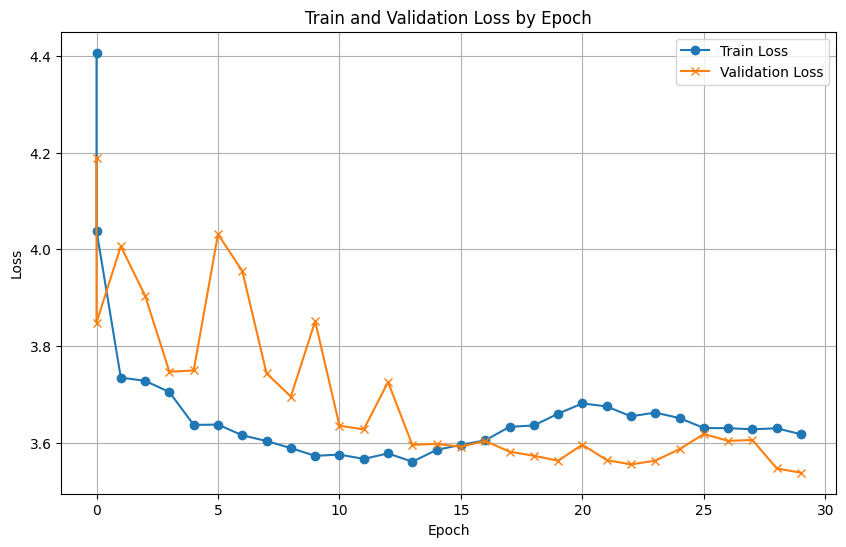

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv(save_path + 'train_metrics.csv', sep=',')
val_df = pd.read_csv(save_path + 'val_metrics.csv', sep=',')

print(train_df.head())
print(train_df.columns)

plt.figure(figsize=(10,6))
plt.plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
plt.plot(val_df['epoch'], val_df['loss'], label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()

## дообучение еще на 10 с фактором 2

       loss        ppx    rouge1    rouge2    rougeL  epoch
0  3.625410  37.540098  0.262836  0.172363  0.262515     30
1  3.688312  39.977311  0.261167  0.170221  0.260649     31
2  3.709873  40.848622  0.262480  0.168035  0.262003     32
3  3.693887  40.200787  0.263374  0.170222  0.263012     33
4  3.675418  39.465133  0.261227  0.168675  0.260819     34
Index(['loss', 'ppx', 'rouge1', 'rouge2', 'rougeL', 'epoch'], dtype='object')


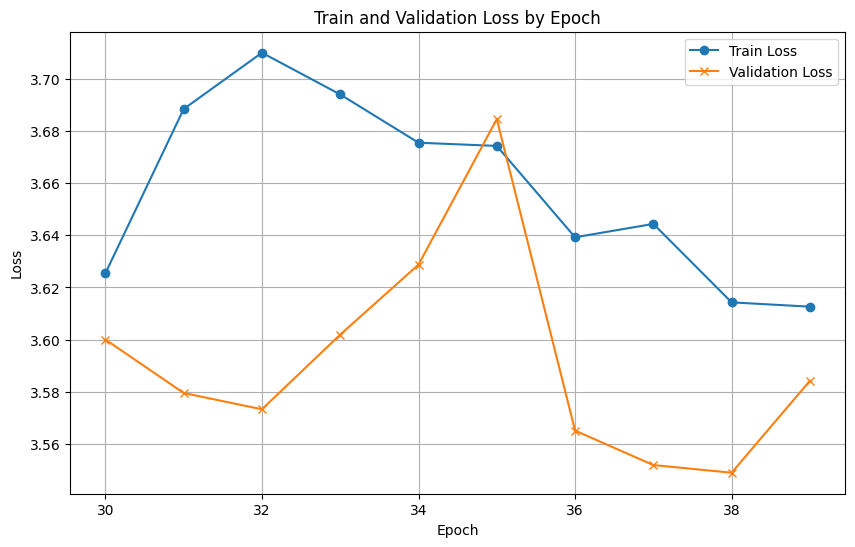

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv(save_path + 'train_metrics_finetuned.csv', sep=',')
val_df = pd.read_csv(save_path + 'val_metrics_finetuned.csv', sep=',')

print(train_df.head())
print(train_df.columns)

plt.figure(figsize=(10,6))
plt.plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
plt.plot(val_df['epoch'], val_df['loss'], label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()

## дообучение еще на 10 с фактором 3

       loss        ppx    rouge1    rouge2    rougeL  epoch
0  3.601567  36.655641  0.265028  0.171264  0.264749     40
1  4.056295  57.759916  0.259581  0.154550  0.249769     40
2  3.800681  44.731624  0.260525  0.164675  0.259625     41
3  3.808526  45.083926  0.258667  0.168522  0.258189     42
4  3.768118  43.298517  0.258178  0.168412  0.257864     43
Index(['loss', 'ppx', 'rouge1', 'rouge2', 'rougeL', 'epoch'], dtype='object')


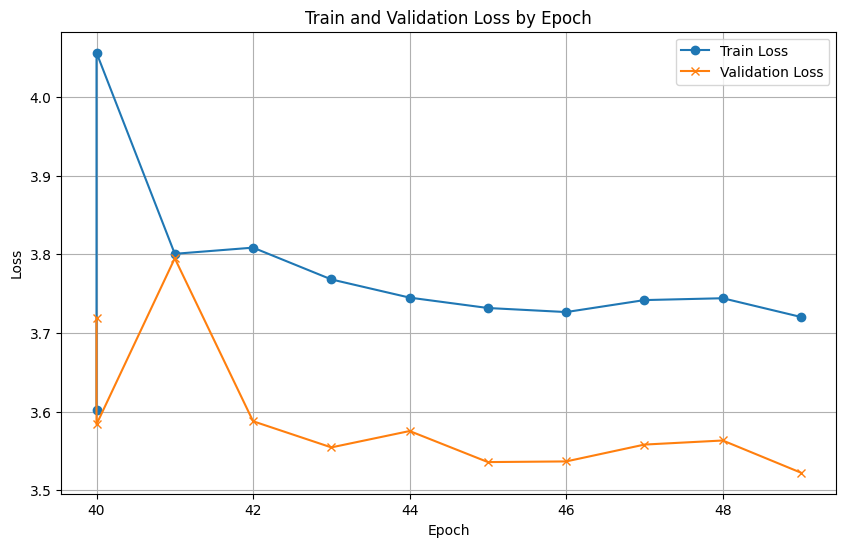

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv(save_path + 'train_metrics_finetuned2.csv', sep=',')
val_df = pd.read_csv(save_path + 'val_metrics_finetuned2.csv', sep=',')

print(train_df.head())
print(train_df.columns)

plt.figure(figsize=(10,6))
plt.plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
plt.plot(val_df['epoch'], val_df['loss'], label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Берем модель с 1ым дообучением

## Общий график

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/коалиция_ниггавуманов/"

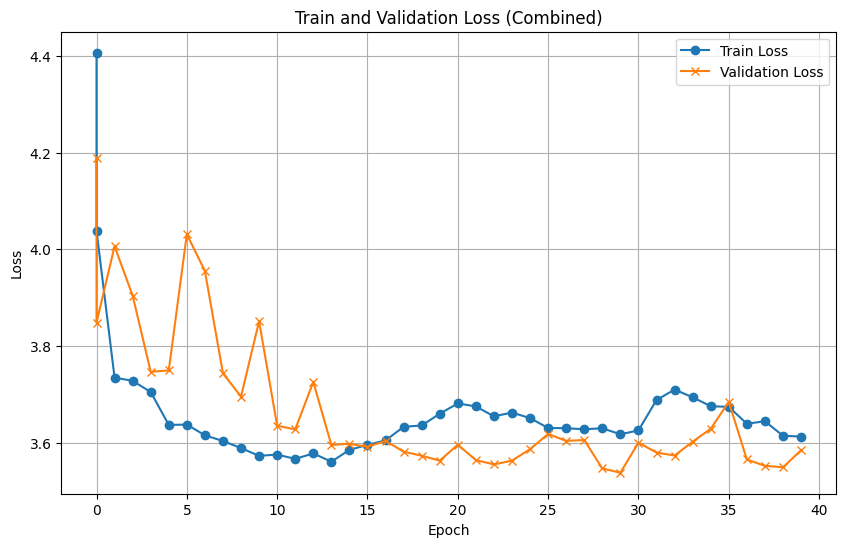

In [ ]:

train_df = pd.read_csv(save_path + 'train_metrics.csv')
val_df = pd.read_csv(save_path + 'val_metrics.csv')

train_finetune_df = pd.read_csv(save_path + 'train_metrics_finetuned.csv')
val_finetune_df = pd.read_csv(save_path + 'val_metrics_finetuned.csv')


train_combined = pd.concat([train_df, train_finetune_df], ignore_index=True)
val_combined = pd.concat([val_df, val_finetune_df], ignore_index=True)


train_combined = train_combined.sort_values(by='epoch').reset_index(drop=True)
val_combined = val_combined.sort_values(by='epoch').reset_index(drop=True)


train_combined.to_csv(save_path + 'train_metrics_combined.csv', index=False)
val_combined.to_csv(save_path + 'val_metrics_combined.csv', index=False)


plt.figure(figsize=(10,6))
plt.plot(train_combined['epoch'], train_combined['loss'], label='Train Loss', marker='o')
plt.plot(val_combined['epoch'], val_combined['loss'], label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Combined)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_metrics(train_metrics_file,
                 val_metrics_file,
                 save_path='training_plots.png'):
    train_df = pd.read_csv(train_metrics_file)
    val_df = pd.read_csv(val_metrics_file)

    metrics = [col for col in train_df.columns if col != 'epoch']

    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Training vs Validation Metrics', fontsize=16)

    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        ax.plot(train_df['epoch'], train_df[metric], label='Train', color='blue')
        ax.plot(val_df['epoch'], val_df[metric], label='Validation', color='orange')

        ax.set_title(metric)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    if n_metrics % n_cols != 0:
        for j in range(i+1, n_rows*n_cols):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


In [ ]:
train_metrics_file = Path('train_metrics.csv')
val_metrics_file = Path('val_metrics.csv')
plot_metrics(train_metrics_file, val_metrics_file)

In [ ]:
import dill

word_field = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
print(" word_field загружен")


vocab = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)
word_field.vocab = vocab
print("vocab подставлен в word_field")

In [ ]:
pad_idx = word_field.vocab.stoi["<pad>"]

criterion = LabelSmoothingLoss(
    smoothing=0.05,
    vocab_size=len(word_field.vocab),
    ignore_index=pad_idx
).to(DEVICE)

optimizer = NoamOpt(model.d_model)

In [ ]:
checkpoint = torch.load(save_path+"nlp_checkpoint1_pupu.pt", map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = checkpoint['noam_step']
start_epoch = checkpoint['epoch'] + 1
best_val_loss = checkpoint['best_val_loss']

fit(
    model,
    criterion,
    optimizer,
    train_iter,
    epochs_count=10,
    val_iter=test_iter,
    save_path1=save_path+"nlp_checkpoint1_pupu_дообучка.pt",
    patience=5,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss
)

## Генерация саммари

In [ ]:
from google.colab import drive
import os

try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive смонтирован успешно.")
except Exception as e:
    print(f"Ошибка при монтировании Google Drive: {e}")

Mounted at /content/drive
Google Drive смонтирован успешно.


In [ ]:
vocab = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)

word_field.vocab = vocab
print("vocab загружен и назначен")

word_field = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
print("word_field загружен целиком")

vocab загружен и назначен
word_field загружен целиком


In [ ]:
model = EncoderDecoder(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb=False
).to(DEVICE)

In [ ]:
model.load_state_dict(torch.load(save_path + "NLP_goyda_finetuned1.pt", map_location=DEVICE))
model.eval()

EncoderDecoder(
  (_out_layer): Linear(in_features=512, out_features=40877, bias=True)
  (embedding_layer): Embedding(40877, 300)
  (embedding_proj): Linear(in_features=300, out_features=512, bias=True)
  (_pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_emb): Sequential(
    (0): Embedding(40877, 300)
    (1): Linear(in_features=300, out_features=512, bias=True)
    (2): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (embedding_layer2): Embedding(40877, 300)
  (embedding_proj2): Linear(in_features=300, out_features=512, bias=True)
  (_pos_enc2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_emb): Sequential(
    (0): Embedding(40877, 300)
    (1): Linear(in_features=300, out_features=512, bias=True)
    (2): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (_emb): Sequential(
      (0): Embedding(40877, 300)
      (1): Linear(in_feat

Генератор суммаризации для модели (выполнил линуксоид)

In [ ]:
lengths = [len(example.target) for example in train_dataset.examples]

print("Максимальная длина заголовка:", max(lengths))
print("Средняя длина заголовка:", sum(lengths) / len(lengths))

Максимальная длина заголовка: 31
Средняя длина заголовка: 8.586416624429802


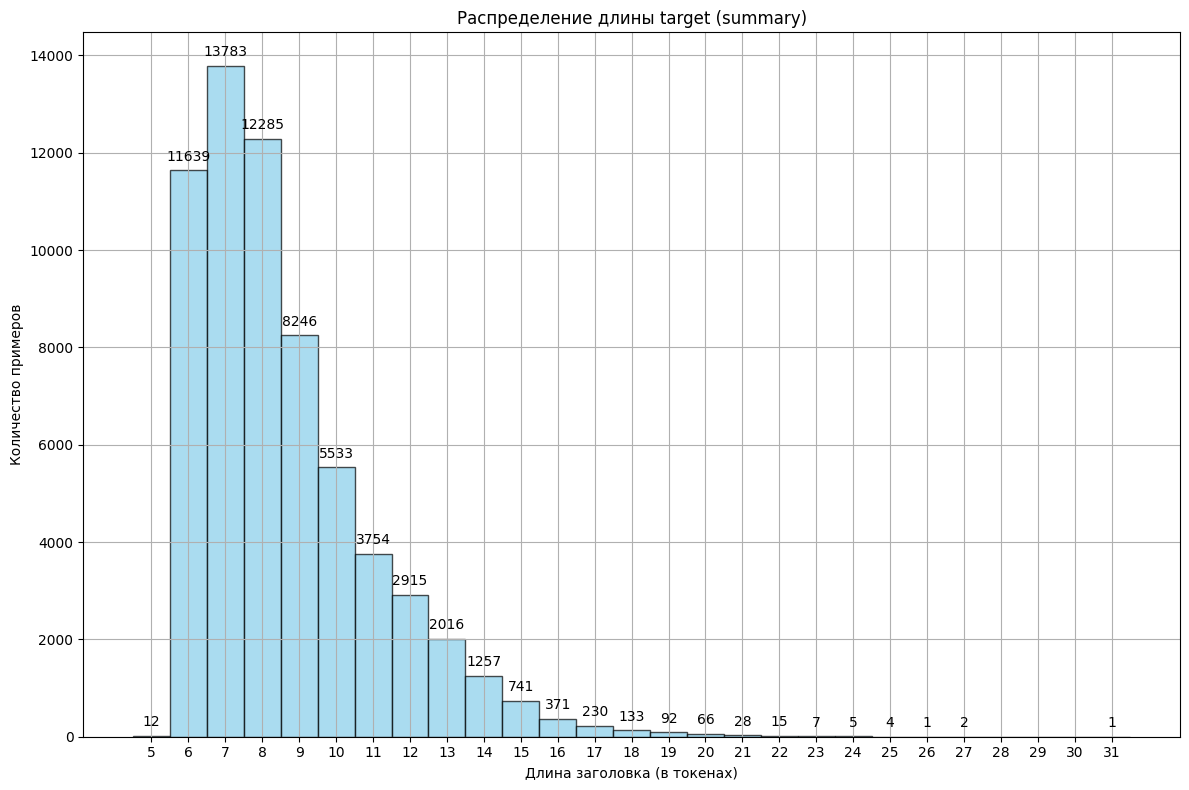

In [ ]:
plt.figure(figsize=(12, 8))
bins = np.arange(min(lengths) - 0.5, max(lengths) + 1.5, 1)
counts, bins_out, patches = plt.hist(lengths, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks(np.arange(min(lengths), max(lengths) + 1, 1))
plt.xlabel("Длина заголовка (в токенах)")
plt.ylabel("Количество примеров")
plt.title("Распределение длины target (summary)")
[plt.text(p.get_x() + p.get_width()/2, c + max(counts)*0.01, int(c), ha='center', va='bottom')
 for c, p in zip(counts, patches) if c > 0]
plt.grid(True)
plt.tight_layout()
plt.show()

Возьмем max_len = 25

In [ ]:
import re
import heapq
import torch
import torch.nn.functional as F

def clean_text(tokens):
    return " ".join(tok for tok in tokens if tok not in {"<s>", "</s>", "<pad>", "<unk>"})

def clean_input_text(text):
    return re.sub(r"<\s*<*\s*[^<>]*?\s*>*\s*>", "", text)

def generate_summary_beam(
    model, src_sentence, src_field, tgt_field, device,
    max_len=20, beam_width=5, length_penalty=0.6, no_repeat_ngram_size=2
):
    model.eval()
    cleaned_sentence = clean_input_text(src_sentence)

    tokens = [src_field.init_token] + src_field.tokenize(cleaned_sentence) + [src_field.eos_token]
    token_ids = [src_field.vocab.stoi.get(t, src_field.vocab.stoi[src_field.unk_token]) for t in tokens]
    src_tensor = torch.LongTensor(token_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != src_field.vocab.stoi[src_field.pad_token]).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        memory = model.encoder(src_tensor, src_mask)

    beams = [(0.0, [tgt_field.vocab.stoi[tgt_field.init_token]])]

    for _ in range(max_len):
        candidates = []
        for score, seq in beams:
            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
            trg_mask = (trg_tensor != tgt_field.vocab.stoi[tgt_field.pad_token]).unsqueeze(1).unsqueeze(2)
            trg_mask = trg_mask & subsequent_mask(trg_tensor.size(1)).to(device)

            with torch.no_grad():
                logits = model.decoder(trg_tensor, memory, src_mask, trg_mask)
                log_probs = F.log_softmax(logits[:, -1], dim=-1)

            if no_repeat_ngram_size > 0 and len(seq) >= no_repeat_ngram_size:
                ngram = tuple(seq[-(no_repeat_ngram_size - 1):])
                for i in range(len(seq) - no_repeat_ngram_size + 1):
                    if tuple(seq[i:i + no_repeat_ngram_size - 1]) == ngram:
                        banned_token = seq[i + no_repeat_ngram_size - 1]
                        log_probs[0, banned_token] = -1e9

            if len(seq) < 5:
                log_probs[0, tgt_field.vocab.stoi[tgt_field.eos_token]] -= 1.0

            topk_probs, topk_ids = log_probs.topk(beam_width)

            for prob, idx in zip(topk_probs[0], topk_ids[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                candidates.append((new_score, new_seq))

        beams = heapq.nlargest(beam_width, candidates, key=lambda x: x[0] / (len(x[1]) ** length_penalty))
        if all(seq[-1] == tgt_field.vocab.stoi[tgt_field.eos_token] for _, seq in beams):
            break

    final_seq = max(beams, key=lambda x: x[0])[1]
    final_tokens = [tgt_field.vocab.itos[i] for i in final_seq]

    return clean_text(final_tokens[1:-1])

In [ ]:
example = test_dataset.examples[53]
input_text = " ".join(example.source)
reference_summary = " ".join(example.target)

generated_summary = generate_summary_beam(
    model=model,
    src_sentence=input_text,
    src_field=word_field,
    tgt_field=word_field,
    device=DEVICE,
    max_len=100,            # или больше
    beam_width=5,
    length_penalty=0.6,
    no_repeat_ngram_size=2
)


In [ ]:
print("Исходный текст:\n", input_text)
print("\n Сгенерированное summary:\n", generated_summary)
print("\n Эталонное summary (реальное):\n", reference_summary)

Исходный текст:
 два военнослужащих объединенной группировки войск в чечне погибли и пять получили ранения в результате подрыва бронемашины федеральных сил в курчалоевском районе республики как сообщили риа новости в штабе огв это произошло в среду < < < eng > > > января вечером на окраине райцентра курчалой бтр федералов съехал на проселочную дорогу машина подорвалась на фугасе нажимного действия установленном на дороге боевиками раненые военнослужащие федеральных сил госпитализированы

 Сгенерированное summary:
 с за в российского еще по на и сша от с с года из из россии московского в против в выборах изнасилование по прошел из детскую на на нефтяное человек тур

 Эталонное summary (реальное):
 на проселке бтр наехал на фугас два человека погибли пять ранены


In [ ]:
print([word_field.vocab.itos[i] for i in range(30)])

['<unk>', '<pad>', '<s>', '</s>', 'сообщает', 'в', 'года', 'человек', 'также', 'россии', 'время', 'на', 'новости', 'риа', 'результате', 'около', 'и', 'данным', 'словам', 'ссылкой', 'году', 'интерфакс', 'сша', 'передает', 'это', 'агентство', 'пока', 'который', 'по', 'пресс']


In [ ]:
custom_text = "преступники будут наказаны за свои злодеяния хохохо"
generated_summary = generate_summary_beam(model, custom_text, word_field, word_field, DEVICE, max_len=25)

print("Кастомный исходный текст:\n", custom_text)
print("\nСгенерированное summary:\n", generated_summary)

Кастомный исходный текст:
 преступники будут наказаны за свои злодеяния хохохо

Сгенерированное summary:
 в свою из преступники президента


In [ ]:
print("беженцы" in word_field.vocab.stoi)
print("украина" in word_field.vocab.stoi)
print("мчс" in word_field.vocab.stoi)

True
True
True


## 5 примеров из тестовой выборки

In [ ]:
import re
import random

def clean_input_text(text):
    text = re.sub(r"<+\s*eng\s*>+", "", text)
    text = re.sub(r"[<>.:]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [ ]:
import random
random.seed(675)

random_indices = random.sample(range(len(test_dataset.examples)), 5)

for i, idx in enumerate(random_indices):
    example = test_dataset.examples[idx]

    raw_text = " ".join(example.source)
    input_text = clean_input_text(raw_text)
    reference = " ".join(example.target)

    summary = generate_summary_beam(
        model=model,
        src_sentence=input_text,
        src_field=word_field,
        tgt_field=word_field,
        device=DEVICE,
        max_len=40,
        beam_width=5,
        length_penalty=0.6,
        no_repeat_ngram_size=2
    )

    print(f"\n=== [{i}] === [index {idx}]")
    print("\nИсходный текст:")
    print(input_text)
    print("\nСгенерированное summary:")
    print(summary)
    print("\nЭталонное summary:")
    print(reference)


=== [0] === [index 8666]

Исходный текст:
знаменитый канадский поп певец джастин бибер принял участие в матче всех звезд национальной хоккейной лиги нхл и был впечатан лицом в борт об этом в понедельник января сообщает видео с эпизодом было опубликовано на -канале подножку -летнему артисту подставил бывший канадский хоккеист один из лучших защитников в истории нхл рэй бурк а толкнул певца в борт другой известный канадский защитник крис пронгер в году вошедший в зал славы нхл -й матч всех звезд нхл прошел в ночь января в лос анджелесе победу в нем одержала сборная столичного дивизиона за которую выступали россияне александр овечкин и сергей бобровский

Сгенерированное summary:
с за в российского актер по на по предъявлено аль из сша тренера к россии и против сторону

Эталонное summary:
джастина бибера впечатали лицом в борт в матче всех звезд нхл

=== [1] === [index 6311]

Исходный текст:
в понедельник января в международном аэропорту шереметьево- при попытке контрабандного вывоза инос

## 5 примеров кастомных

In [ ]:
custom_texts = [
    """В Санкт-Петербурге прошёл ежегодный фестиваль уличного искусства, на котором выступили более 50 художников из разных городов России. Мероприятие собрало тысячи зрителей и вызвало большой интерес в социальных сетях. Организаторы планируют расширить программу в следующем году и пригласить зарубежных участников.""",

    """В Новосибирске открыли новый научно-технический парк, который призван поддерживать стартапы и инновационные проекты. В церемонии открытия приняли участие представители правительства региона и ведущие учёные. Парк оснащён современным оборудованием и предоставляет резидентам льготные условия аренды и консультации экспертов.""",

    """Минздрав России сообщил о запуске новой программы профилактики заболеваний сердечно-сосудистой системы. Программа включает бесплатные обследования для лиц старше 40 лет и образовательные кампании в регионах. Ожидается, что инициатива поможет снизить уровень смертности от инфарктов и инсультов.""",

    """В Москве состоялась конференция по развитию искусственного интеллекта, на которой ведущие специалисты обсудили перспективы применения технологий в промышленности и медицине. Участники отметили важность междисциплинарного сотрудничества и необходимость создания нормативной базы для безопасного использования ИИ.""",

    """В Краснодарском крае завершился чемпионат по пляжному волейболу, который собрал спортсменов из 15 регионов страны. Победу одержала команда из Сочи, которая в финале обыграла соперников со счётом 2:1. Организаторы отметили высокий уровень соревнований и выразили намерение сделать турнир ежегодным."""
]

In [ ]:
for i, text in enumerate(custom_texts):
    summary = generate_summary_beam(
        model=model,
        src_sentence=text,
        src_field=word_field,
        tgt_field=word_field,
        device=DEVICE,
        max_len=40,
        beam_width=3,
        length_penalty=0.2,
        no_repeat_ngram_size=2
    )

    print(f"=== [{i}] ===")
    print("Text:", text)
    print("Generated summary:", summary)
    print()

=== [0] ===
Text: В Санкт-Петербурге прошёл ежегодный фестиваль уличного искусства, на котором выступили более 50 художников из разных городов России. Мероприятие собрало тысячи зрителей и вызвало большой интерес в социальных сетях. Организаторы планируют расширить программу в следующем году и пригласить зарубежных участников.
Generated summary: с премии за искусства в человека по к на в россии

=== [1] ===
Text: В Новосибирске открыли новый научно-технический парк, который призван поддерживать стартапы и инновационные проекты. В церемонии открытия приняли участие представители правительства региона и ведущие учёные. Парк оснащён современным оборудованием и предоставляет резидентам льготные условия аренды и консультации экспертов.
Generated summary: стартапы по доллара парк на македонии от с в россии за

=== [2] ===
Text: Минздрав России сообщил о запуске новой программы профилактики заболеваний сердечно-сосудистой системы. Программа включает бесплатные обследования для лиц старше 40 л

# Визуализация attention

In [ ]:
class AttentionData():
    def __init__(self, model, word_field, inp_text, out_text):
        self.enc_self_attn = model.encoder.attn_probs
        self.dec_self_attn = model.decoder.self_attn_probs
        self.dec_enc_attn = model.decoder.enc_attn_probs
        self.tokens_inp = [word_field.init_token] + word_field.tokenize(inp_text.lower()) + [word_field.eos_token]
        self.tokens_out = [word_field.init_token] + word_field.tokenize(out_text.lower()) + [word_field.eos_token]
    def visualize(self, layer, head, mode = 0):
        #mode = 0 -> enc_self_attn
        #mode = 1 -> dec_self_attn
        #mode = 2 -> dec_enc_attn
        if mode == 0:
            arr = self.enc_self_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_inp
            title = "enc_self_attn"
        if mode == 1:
            arr = self.dec_self_attn
            x_tokens = self.tokens_out
            y_tokens = self.tokens_out
            title = "dec_self_attn"
        if mode == 2:
            arr = self.dec_enc_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_out
            title = "dec_enc_attn"

        arr = arr[layer].cpu().numpy()[0][head]
        plt.figure(figsize=(10, 8))
        sns.heatmap(arr, xticklabels=x_tokens, yticklabels=y_tokens, cmap='viridis')
        plt.title(f"Attention Weights for {title} (Layer {layer}, Head {head})")
        plt.xlabel("Input Tokens")
        plt.ylabel("Output Tokens")
        plt.show()

In [ ]:
vocab = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)

word_field.vocab = vocab
print("vocab загружен и назначен")

word_field = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
print("word_field загружен целиком")

vocab загружен и назначен
word_field загружен целиком


In [ ]:
model = EncoderDecoder(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb=False
).to(DEVICE)

NameError: name 'pretrained_embeddings' is not defined

In [ ]:
model = EncoderDecoder(source_vocab_size=len(word_field.vocab),
                       target_vocab_size=len(word_field.vocab),save_probs = True).to(DEVICE)
model.load_state_dict(torch.load(save_path + "NLP_goyda_finetuned1.pt", map_location=torch.device('cpu')))
model.eval()

# Сравнение метрик модифицированной модели и baseline

In [ ]:
def evaluate_model(model, word_field, val_iter):
    model.eval()
    pad_idx = word_field.vocab.stoi["<pad>"]

    criterion = LabelSmoothingLoss(
        smoothing=0.05,
        vocab_size=len(word_field.vocab),
        ignore_index=pad_idx
    ).to(DEVICE)

    val_metrics = do_epoch(model, criterion, val_iter, None, "Evaluation:", teacher_forcing_ratio=0.0)
    return val_metrics

## baseline:

In [ ]:
class EncoderBase(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False):
        super().__init__()
        self._emb = nn.Sequential(
                        nn.Embedding(vocab_size, d_model),
                        PositionalEncoding(d_model, dropout_rate)
                    )
        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.attn_probs = []

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)
        self.attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, mask)
            if self.save_probs:
                self.attn_probs.append(block._self_attn._attn_probs)

        return self._norm(inputs)

In [ ]:
class DecoderBase(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False):
        super().__init__()
        self._out_layer = nn.Linear(d_model, vocab_size)

        self._emb = nn.Sequential(
                        nn.Embedding(vocab_size, d_model),
                        PositionalEncoding(d_model, dropout_rate)
                    )

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)


        self.save_probs = save_probs
        self.self_attn_probs = []
        self.enc_attn_probs = []

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        self.self_attn_probs = []
        self.enc_attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            if self.save_probs:
                self.self_attn_probs.append(block._self_attn._attn_probs)
                self.enc_attn_probs.append(block._encoder_attn._attn_probs)
        return self._out_layer(self._norm(inputs))

In [ ]:
class EncoderDecoderBase(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1, save_probs = False):
        super(EncoderDecoderBase, self).__init__()

        self.d_model = d_model
        self.encoder = EncoderBase(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs)
        self.decoder = DecoderBase(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs)
        # self.generator = Generator(d_model, target_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

In [ ]:
nlp = spacy.load("ru_core_news_sm")
ru_stopwords = set(stopwords.words("russian"))

def spacy_tokenize(text):
    return [
        token.text.lower()
        for token in nlp(text)
        if not token.is_space and not token.is_punct
    ]
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

word_field = Field(
    tokenize=spacy_tokenize,
    init_token=BOS_TOKEN,
    eos_token=EOS_TOKEN,
    unk_token=UNK_TOKEN,
    pad_token=PAD_TOKEN,
    lower=False,
    include_lengths=True
)
fields = [("source", word_field), ("target", word_field)]

In [ ]:
vocab = torch.load(save_path + "vocab_baseline.pt", pickle_module=dill)

word_field.vocab = vocab
print("vocab загружен и назначен")


vocab загружен и назначен


In [ ]:
model_base = EncoderDecoderBase(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    save_probs = True
).to(DEVICE)

In [ ]:
model_base.load_state_dict(torch.load(save_path + "base_model_30.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
baseline_eval_metrics = evaluate_model(model_base, word_field, test_iter)

  0%|          | 0/349 [00:00<?, ?it/s]

In [ ]:
baseline_eval_metrics

{'loss': 8.805031790091178,
 'ppx': 6667.710256493519,
 'rouge1': 0.20832108199300564,
 'rouge2': 0.036636778289112694,
 'rougeL': 0.20830118387138832}

In [ ]:
save_metrics(Path(save_path+'baseline_eval_metrics'), 'eval', baseline_eval_metrics)

# Модифицированная модель

In [ ]:
word_field_new = torch.load(save_path + "word_field_nlp_pupupu.pt", pickle_module=dill)
print("word_field загружен целиком")
vocab_new = torch.load(save_path + "vocab_nlp_pupupu.pt", pickle_module=dill)

word_field_new.vocab = vocab_new
print("vocab загружен и назначен")



word_field загружен целиком
vocab загружен и назначен


In [ ]:
fasttext_path = save_path + "cc.ru.300.vec"
vectors = {}
with open(fasttext_path, 'r', encoding='utf-8') as f:
    next(f)
    for line in f:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)

        norm = np.linalg.norm(vector)
        if norm > 0:
            vector /= norm

        vectors[word] = vector

embedding_dim = 300
embedding_matrix = np.random.normal(scale=0.01, size=(len(word_field_new.vocab), embedding_dim))

for i in range(len(embedding_matrix)):
    if word_field.vocab.itos[i] not in vectors:
        norm = np.linalg.norm(embedding_matrix[i])
        if norm > 0:
            embedding_matrix[i] /= norm
for i, token in enumerate(word_field_new.vocab.itos):
    if token in vectors:
        embedding_matrix[i] = vectors[token]

pretrained_embeddings = torch.tensor(embedding_matrix, dtype=torch.float)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset),
    batch_sizes=(16, 32),
    shuffle=True,
    device=DEVICE,
    sort=False,
    sort_key=lambda x: len(x.source),
)

In [ ]:
model_new = EncoderDecoder(
    source_vocab_size=len(word_field_new.vocab),
    target_vocab_size=len(word_field_new.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb=False,
    save_probs = True
).to(DEVICE)

In [ ]:
model_new.load_state_dict(torch.load(save_path + "NLP_goyda_finetuned1.pt", map_location=torch.device('cpu')))


<All keys matched successfully>

'/content/'

In [ ]:
new_eval_metrics = evaluate_model(model_new, word_field_new, test_iter)

  0%|          | 0/349 [00:00<?, ?it/s]

In [ ]:
new_eval_metrics

{'loss': 3.7461792466292065,
 'ppx': 42.358929402483845,
 'rouge1': 0.2603699349988695,
 'rouge2': 0.1709281044695179,
 'rougeL': 0.26031251451713067}

In [ ]:
save_metrics(Path(save_path+'new_eval_metrics'), 'eval', new_eval_metrics)

# Визуализация Attention

In [ ]:
class AttentionData():
    def __init__(self, model, word_field, inp_text, out_text):
        self.enc_self_attn = model.encoder.attn_probs
        self.dec_self_attn = model.decoder.self_attn_probs
        self.dec_enc_attn = model.decoder.enc_attn_probs
        self.tokens_inp = [word_field.init_token] + word_field.tokenize(inp_text.lower()) + [word_field.eos_token]
        self.tokens_out = [word_field.init_token] + word_field.tokenize(out_text.lower()) + [word_field.eos_token]

    def visualize(self, layer, head, mode=0, save_path=None):
        if mode == 0:
            arr = self.enc_self_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_inp
            title = "enc_self_attn"
        elif mode == 1:
            arr = self.dec_self_attn
            x_tokens = self.tokens_out
            y_tokens = self.tokens_out
            title = "dec_self_attn"
        elif mode == 2:
            arr = self.dec_enc_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_out
            title = "dec_enc_attn"
        else:
            raise ValueError("Invalid mode. Use 0, 1, or 2.")

        attn_tensor = arr[layer][0][0]

        attn_map = attn_tensor[head].cpu().numpy()
        if attn_map.ndim != 2:
            raise ValueError(f"Expected 2D attention map, got shape: {attn_map.shape}")

        # Plotting
        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_map, xticklabels=x_tokens, yticklabels=y_tokens, cmap='viridis')
        plt.title(f"Attention Weights for {title} (Layer {layer}, Head {head})")
        plt.xlabel("Input Tokens")
        plt.ylabel("Output Tokens")

        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_visualize_attention(custom_texts, model, word_field, generate_summary_beam, DEVICE, MAX_LAYERS, MAX_HEADS, output_dir='attention_maps'):
    os.makedirs(output_dir, exist_ok=True)

    for i, text in enumerate(custom_texts):
        summary = generate_summary_beam(model, text, word_field, word_field, DEVICE)
        print(f"=== [{i}] ===")
        print("Text:", text)
        print("Generated summary:", summary)
        print()

        ad = AttentionData(model, word_field, text, summary)
        text_dir = os.path.join(output_dir, f"text_{i}")
        os.makedirs(text_dir, exist_ok=True)

        for mode in range(3):  # 0 = enc_self_attn, 1 = dec_self_attn, 2 = dec_enc_attn
            for layer in range(MAX_LAYERS):
                for head in range(MAX_HEADS):
                    filename = f"text_{i}_mode_{mode}_head_{head}_layer_{layer}.png"
                    save_path = os.path.join(text_dir, filename)
                    ad.visualize(layer=layer, head=head, mode=mode, save_path=save_path)

In [ ]:
MAX_LAYERS = 3
MAX_HEADS = 7

process_and_visualize_attention(
    custom_texts=custom_texts,
    model=model_new,
    word_field=word_field_new,
    generate_summary_beam=generate_summary_beam,
    DEVICE=DEVICE,
    MAX_LAYERS=MAX_LAYERS,
    MAX_HEADS=MAX_HEADS, output_dir='attention_maps_new_2'
)

=== [0] ===
Text: В Санкт-Петербурге прошёл ежегодный фестиваль уличного искусства, на котором выступили более 50 художников из разных городов России. Мероприятие собрало тысячи зрителей и вызвало большой интерес в социальных сетях. Организаторы планируют расширить программу в следующем году и пригласить зарубежных участников.
Generated summary: сборной вооруженного в новый по и в президента от

=== [1] ===
Text: В Новосибирске открыли новый научно-технический парк, который призван поддерживать стартапы и инновационные проекты. В церемонии открытия приняли участие представители правительства региона и ведущие учёные. Парк оснащён современным оборудованием и предоставляет резидентам льготные условия аренды и консультации экспертов.
Generated summary: забил в сша задержаны на памятник по из решили

=== [2] ===
Text: Минздрав России сообщил о запуске новой программы профилактики заболеваний сердечно-сосудистой системы. Программа включает бесплатные обследования для лиц старше 40 лет и обр

In [ ]:
from google.colab import files
import shutil

folder_path = "/content/attention_maps_new_2"

output_filename = "/content/attention_maps_new_2.zip"
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
MAX_LAYERS = 3
MAX_HEADS = 7

process_and_visualize_attention(
    custom_texts=custom_texts,
    model=model,
    word_field=word_field,
    generate_summary_beam=generate_summary_beam,
    DEVICE=DEVICE,
    MAX_LAYERS=MAX_LAYERS,
    MAX_HEADS=MAX_HEADS, output_dir='attention_maps_base'
)

=== [0] ===
Text: В Санкт-Петербурге прошёл ежегодный фестиваль уличного искусства, на котором выступили более 50 художников из разных городов России. Мероприятие собрало тысячи зрителей и вызвало большой интерес в социальных сетях. Организаторы планируют расширить программу в следующем году и пригласить зарубежных участников.
Generated summary: порезы олбрайт способность курган встреча филиалы владельцев обновленном боеголовка боеголовка пограничного филиалы распоряжений порезы скотт ремень 351 филиалы дневное

=== [1] ===
Text: В Новосибирске открыли новый научно-технический парк, который призван поддерживать стартапы и инновационные проекты. В церемонии открытия приняли участие представители правительства региона и ведущие учёные. Парк оснащён современным оборудованием и предоставляет резидентам льготные условия аренды и консультации экспертов.
Generated summary: порезы олбрайт способность курган встреча филиалы вазиани обновленном боеголовка филиалы 34-й филиалы объектам порезы пор

In [ ]:
folder_path = "/content/attention_maps_base"

output_filename = "/content/attention_maps_base.zip"
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Выводы по проделанной работе

## Микишева М.:
### Словарь и эмббединги

	•	Загружен и токенизирован датасет с использованием spaCy.
	•	Построен единый словарь (Field) с токенами <s>, </s>, <pad>, <unk>.
	•	Применены стоп-слова NLTK — их частоты снижены в словаре.
	•	Построен словарь из 40 877 токенов, отфильтрованы слова с freq < 10.

	Разные значения min_freq были протестированы, а также разные способы токенизации и сборки
	•	Загружены и нормализованы русские FastText-вектора (cc.ru.300.vec).
	•	Составлена embedding_matrix (размер [40877 × 300], покрытие 92.42%).
	•	Созданы train/test выборки и BucketIterator для обучения на GPU.
	•	Выполнена визуализация векторов (t-SNE, семантические кластеры).
	•	Проведён анализ UNK в тесте
	•	Проведён частотный анализ словаря — топ и хвост, распределение логарифмическое

   Словарь собран хорошо, покрытие векторами высокое

### Label smoothing
	Реализирован  LabelSmoothingLoss вместо CrossEntropyLoss.

### Generate summary

	•	 Протестированы разные варианты генерации саммари - с beam search, также пробовала greedy decoding
	•	Протестированы разные max_len, штраф за ранний <eos>, n-gram suppression
	• Тестировали генерацию на реальных и кастомных примерах

  

# Кладовая говнокода

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False, embeddings = None):
        super().__init__()
        if embeddings is None:
            self._emb = nn.Sequential(
                nn.Embedding(vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
        else self._emb = enmbeddings

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.attn_probs = []

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)
        self.attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, mask)
            if self.save_probs:
                self.attn_probs.append(block._self_attn._attn_probs)

        return self._norm(inputs)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs = False, embeddings = None):
        super().__init__()
        if embeddings is None:
            self._emb = nn.Sequential(
                nn.Embedding(vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
            self._out_layer = nn.Linear(d_model, vocab_size)
        else:
            self._emb = embeddings
            self._out_layer = nn.Linear(d_model, vocab_size)
            self._out_layer.weight = self._emb[0].weight  # Весовая привязка


        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)


        self.save_probs = save_probs
        self.self_attn_probs = []
        self.enc_attn_probs = []

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)
        self.self_attn_probs = []
        self.enc_attn_probs = []
        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            if self.save_probs:
                self.self_attn_probs.append(block._self_attn._attn_probs)
                self.enc_attn_probs.append(block._encoder_attn._attn_probs)
        return self._out_layer(self._norm(inputs))

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1, save_probs = False, shared_emb = False):
        super(EncoderDecoder, self).__init__()

        embeddings = None
        if shared_emb:
            assert source_vocab_size == target_vocab_size, "Vocab sizes must match for shared embeddings"
            self._emb = nn.Sequential(
                nn.Embedding(vocab_size, d_model),
                PositionalEncoding(d_model, dropout_rate)
            )
            embeddings = self._emb


        self.d_model = d_model
        self.encoder = Encoder(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs, embeddings)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, save_probs, embeddings)
        # self.generator = Generator(d_model, target_vocab_size)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)

In [ ]:
with open("/content/vocab.pkl", "rb") as f:
    word_field = dill.load(f)

In [ ]:
model = EncoderDecoder(source_vocab_size=len(word_field.vocab),
                       target_vocab_size=len(word_field.vocab),save_probs = True).to(DEVICE)
weights_path = "/content/model_summary.pt"
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (_emb): Sequential(
      (0): Embedding(55919, 256)
      (1): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (_blocks): ModuleList(
      (0-3): 4 x EncoderBlock(
        (_self_attn): MultiHeadedAttention(
          (_attention): ScaledDotProductAttention(
            (_dropout): Dropout(p=0.1, inplace=False)
          )
          (_w_q): Linear(in_features=256, out_features=256, bias=True)
          (_w_k): Linear(in_features=256, out_features=256, bias=True)
          (_w_v): Linear(in_features=256, out_features=256, bias=True)
          (_w_o): Linear(in_features=256, out_features=256, bias=True)
        )
        (_feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=256, out_features=1024, bias=True)
          (w_2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (_self_attention_block): ResidualBloc

In [ ]:
class AttentionData():
    def __init__(self, model, word_field, inp_text, out_text):
        self.enc_self_attn = model.encoder.attn_probs
        self.dec_self_attn = model.decoder.self_attn_probs
        self.dec_enc_attn = model.decoder.enc_attn_probs
        self.tokens_inp = [word_field.init_token] + word_field.tokenize(inp_text.lower()) + [word_field.eos_token]
        self.tokens_out = [word_field.init_token] + word_field.tokenize(out_text.lower()) + [word_field.eos_token]
    def visualize(self, layer, head, mode = 0):
        #mode = 0 -> enc_self_attn
        #mode = 1 -> dec_self_attn
        #mode = 2 -> dec_enc_attn
        if mode == 0:
            arr = self.enc_self_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_inp
            title = "enc_self_attn"
        if mode == 1:
            arr = self.dec_self_attn
            x_tokens = self.tokens_out
            y_tokens = self.tokens_out
            title = "dec_self_attn"
        if mode == 2:
            arr = self.dec_enc_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_out
            title = "dec_enc_attn"

        arr = arr[layer].cpu().numpy()[0][head]
        plt.figure(figsize=(10, 8))
        sns.heatmap(arr, xticklabels=x_tokens, yticklabels=y_tokens, cmap='viridis')
        plt.title(f"Attention Weights for {title} (Layer {layer}, Head {head})")
        plt.xlabel("Input Tokens")
        plt.ylabel("Output Tokens")
        plt.show()

In [ ]:
import seaborn as sns

In [ ]:
ad = AttentionData(model,word_field,custom_text,generated_summary)

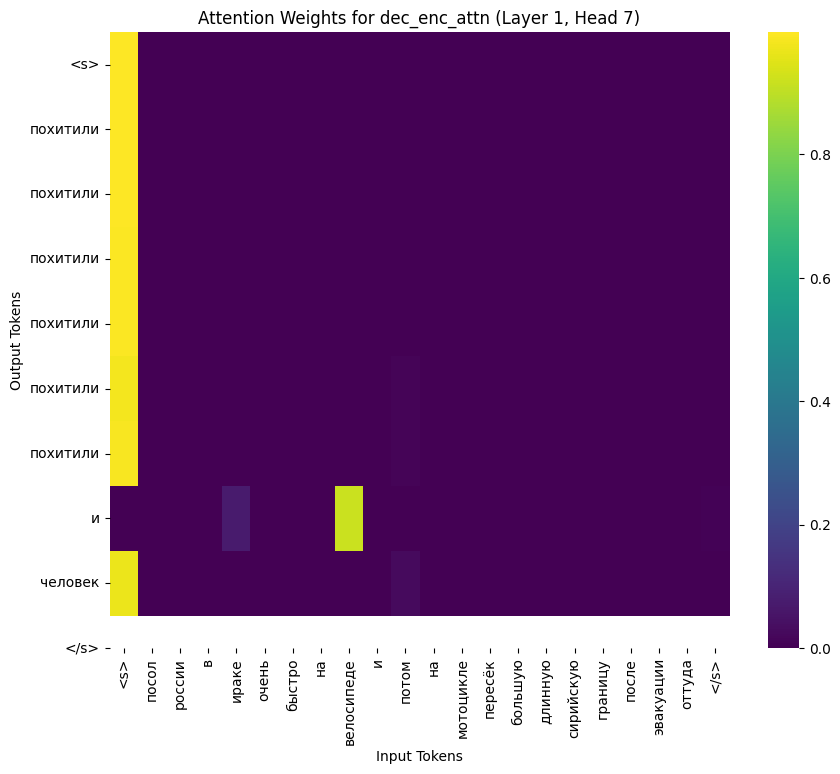

In [ ]:
layer = 1
head = 7
mode = 2
ad.visualize(layer,head,mode)

In [ ]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=1d4acd9b1160f231c1d4d5c22672cb9335831c77e15f985d735ae6c34d25b57c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
tqdm.get_lock().locks = []
from rouge_score import rouge_scorer

def do_epoch(model, criterion, data_iter, optimizer=None, name=None, teacher_forcing_ratio=0.5):
    epoch_loss = 0
    total_rouge1 = 0
    total_rouge2 = 0
    total_rougeL = 0

    is_train = optimizer is not None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                encoder_output = model.encoder(source_inputs, source_mask)

                batch_size, target_len = target_inputs.size()

                output_teacher = target_inputs[:, 0].unsqueeze(1)  # Для обучения (с Teacher Forcing)
                output_autoregressive = target_inputs[:, 0].unsqueeze(1)  # Для ROUGE (без Teacher Forcing)

                for t in range(1, target_len):
                    # Общая часть: вычисление logits для обоих режимов
                    logits_teacher = model.decoder(output_teacher, encoder_output, source_mask, target_mask[:, :t, :t])
                    logits_autoregressive = model.decoder(output_autoregressive, encoder_output, source_mask, target_mask[:, :t, :t])

                    next_token_logits = logits_teacher[:, -1, :]
                    next_token = next_token_logits.argmax(dim=-1)

                    # Teacher Forcing для обучения
                    teacher_force = random.random() < teacher_forcing_ratio
                    next_input_teacher = target_inputs[:, t] if teacher_force else next_token
                    next_input_teacher = next_input_teacher.unsqueeze(1)
                    output_teacher = torch.cat((output_teacher, next_input_teacher), dim=1)

                    # Авторегрессия для ROUGE
                    next_input_autoregressive = next_token
                    output_autoregressive = torch.cat((output_autoregressive, next_input_autoregressive.unsqueeze(1)), dim=1)

                # Вычисление потерь на предсказаниях с Teacher Forcing
                logits = model.decoder(output_teacher[:, :-1], encoder_output, source_mask, target_mask[:, :-1, :-1])
                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)
                epoch_loss += loss.item()


                # Вычисление ROUGE на авторегрессионных предсказаниях
                pred_sentences = decode_tokens(output_autoregressive, vocab)
                target_sentences = decode_tokens(target_inputs[:, 1:], vocab)  # Игнорируем начальный токен


                # Считаем метрики Rouge
                batch_rouge1 = 0
                batch_rouge2 = 0
                batch_rougeL = 0
                for pred, ref in zip(pred_sentences, target_sentences):
                    scores = scorer.score(ref, pred)
                    batch_rouge1 += scores['rouge1'].fmeasure
                    batch_rouge2 += scores['rouge2'].fmeasure
                    batch_rougeL += scores['rougeL'].fmeasure

                total_rouge1 += batch_rouge1 / batch_size
                total_rouge2 += batch_rouge2 / batch_size
                total_rougeL += batch_rougeL / batch_size


                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description(
                    '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                        name, loss.item(), math.exp(loss.item()),
                        batch_rouge1 / batch_size, batch_rouge2 / batch_size, batch_rougeL / batch_size
                    )
                )


            avg_loss = epoch_loss / batches_count
            avg_rouge1 = total_rouge1 / batches_count
            avg_rouge2 = total_rouge2 / batches_count
            avg_rougeL = total_rougeL / batches_count

            progress_bar.set_description(
                '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                    name, avg_loss, math.exp(avg_loss), avg_rouge1, avg_rouge2, avg_rougeL
                )
            )
            progress_bar.refresh()

    return {
        'loss': avg_loss,
        'ppx': math.exp(avg_loss),
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    }

def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None,
        save_path1=None, patience=7, start_epoch=0, best_val_loss=float('inf')):

    epochs_no_improve = 0
    best_model_state = None

    initial_teacher_forcing = 0.7
    min_teacher_forcing = 0.1
    decay_rate = 0.03

    for epoch in range(start_epoch, start_epoch + epochs_count):
        name_prefix = f"[{epoch + 1} / {start_epoch + epochs_count}] "
        teacher_forcing_ratio = max(min_teacher_forcing, initial_teacher_forcing - decay_rate * epoch)

        train_loss = do_epoch(model, criterion, train_iter, optimizer, name_prefix + "Train:", teacher_forcing_ratio)

        if val_iter is not None:
            metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)
            val_loss = metrics['loss']

            if val_loss < best_val_loss - 1e-4:  # небольшая дельта, чтобы избежать флуктуаций
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best model found! val_loss={val_loss:.4f}")
                if save_path1:
                    torch.save({
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.optimizer.state_dict(),
                        'noam_step': optimizer._step,
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, save_path1)
            else:
                epochs_no_improve += 1
                print(f"No improvement. Patience: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    if save_path and best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {teacher_forcing_ratio:.2f}")





def decode_tokens(tensor, vocab, skip_tokens=('<pad>', '<sos>', '<eos>')):
    """
    Декодирует тензор с индексами токенов в строки, пропуская служебные токены.

    Args:
        tensor (torch.Tensor): Тензор формы [batch_size, seq_len].
        vocab (torchtext.vocab.Vocab): Словарь для преобразования индексов в слова.
        skip_tokens (tuple): Токены, которые нужно пропустить (например, паддинг).

    Returns:
        list[str]: Декодированные предложения.
    """
    sentences = []
    skip_ids = [vocab.stoi[token] for token in skip_tokens if token in vocab.stoi]

    for seq in tensor:
        tokens = [
            vocab.itos[token.item()]
            for token in seq
            if token.item() not in skip_ids
        ]
        sentences.append(" ".join(tokens))

    return sentences

In [ ]:
tqdm.get_lock().locks = []
from rouge_score import rouge_scorer

def do_epoch(model, criterion, data_iter, optimizer=None, name=None, teacher_forcing_ratio=0.5):
    epoch_loss = 0
    total_rouge1 = 0
    total_rouge2 = 0
    total_rougeL = 0

    is_train = optimizer is not None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                encoder_output = model.encoder(source_inputs, source_mask)

                batch_size, target_len = target_inputs.size()

                output_teacher = target_inputs[:, 0].unsqueeze(1)  # Для обучения (с Teacher Forcing)
                output_autoregressive = target_inputs[:, 0].unsqueeze(1)  # Для ROUGE (без Teacher Forcing)

                for t in range(1, target_len):
                    # Общая часть: вычисление logits для обоих режимов
                    logits_teacher = model.decoder(output_teacher, encoder_output, source_mask, target_mask[:, :t, :t])
                    logits_autoregressive = model.decoder(output_autoregressive, encoder_output, source_mask, target_mask[:, :t, :t])

                    next_token_logits = logits_teacher[:, -1, :]
                    next_token = next_token_logits.argmax(dim=-1)

                    # Teacher Forcing для обучения
                    teacher_force = random.random() < teacher_forcing_ratio
                    next_input_teacher = target_inputs[:, t] if teacher_force else next_token
                    next_input_teacher = next_input_teacher.unsqueeze(1)
                    output_teacher = torch.cat((output_teacher, next_input_teacher), dim=1)

                    # Авторегрессия для ROUGE
                    next_input_autoregressive = next_token
                    output_autoregressive = torch.cat((output_autoregressive, next_input_autoregressive.unsqueeze(1)), dim=1)

                # Вычисление потерь на предсказаниях с Teacher Forcing
                logits = model.decoder(output_teacher[:, :-1], encoder_output, source_mask, target_mask[:, :-1, :-1])
                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)
                epoch_loss += loss.item()


                # Вычисление ROUGE на авторегрессионных предсказаниях
                pred_sentences = decode_tokens(output_autoregressive, vocab)
                target_sentences = decode_tokens(target_inputs[:, 1:], vocab)  # Игнорируем начальный токен


                # Считаем метрики Rouge
                batch_rouge1 = 0
                batch_rouge2 = 0
                batch_rougeL = 0
                for pred, ref in zip(pred_sentences, target_sentences):
                    scores = scorer.score(ref, pred)
                    batch_rouge1 += scores['rouge1'].fmeasure
                    batch_rouge2 += scores['rouge2'].fmeasure
                    batch_rougeL += scores['rougeL'].fmeasure

                total_rouge1 += batch_rouge1 / batch_size
                total_rouge2 += batch_rouge2 / batch_size
                total_rougeL += batch_rougeL / batch_size


                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description(
                    '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                        name, loss.item(), math.exp(loss.item()),
                        batch_rouge1 / batch_size, batch_rouge2 / batch_size, batch_rougeL / batch_size
                    )
                )


            avg_loss = epoch_loss / batches_count
            avg_rouge1 = total_rouge1 / batches_count
            avg_rouge2 = total_rouge2 / batches_count
            avg_rougeL = total_rougeL / batches_count

            progress_bar.set_description(
                '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                    name, avg_loss, math.exp(avg_loss), avg_rouge1, avg_rouge2, avg_rougeL
                )
            )
            progress_bar.refresh()

    return {
        'loss': avg_loss,
        'ppx': math.exp(avg_loss),
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    }

def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None,
        save_path1=None, patience=7, start_epoch=0, best_val_loss=float('inf'),
        train_metrics_file = Path('train_metrics.csv'), val_metrics_file = Path('val_metrics.csv')):

    epochs_no_improve = 0
    best_model_state = None

    initial_teacher_forcing = 0.7
    min_teacher_forcing = 0.1
    decay_rate = 0.03

    for epoch in range(start_epoch, start_epoch + epochs_count):
        name_prefix = f"[{epoch + 1} / {start_epoch + epochs_count}] "
        teacher_forcing_ratio = max(min_teacher_forcing, initial_teacher_forcing - decay_rate * epoch)

        train_metrics = do_epoch(model, criterion, train_iter, optimizer, name_prefix + "Train:", teacher_forcing_ratio)
        train_loss = train_metrics['loss']
        save_metrics(train_metrics_file,epoch,train_metrics)
        if val_iter is not None:
            val_metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)
            val_loss = val_metrics['loss']
            save_metrics(val_metrics_file,epoch,val_metrics)



            if val_loss < best_val_loss - 1e-4:  # небольшая дельта, чтобы избежать флуктуаций
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best model found! val_loss={val_loss:.4f}")
                if save_path1:
                    torch.save({
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.optimizer.state_dict(),
                        'noam_step': optimizer._step,
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, save_path1)
            else:
                epochs_no_improve += 1
                print(f"No improvement. Patience: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    if save_path and best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {teacher_forcing_ratio:.2f}")





def decode_tokens(tensor, vocab, skip_tokens=('<pad>', '<sos>', '<eos>')):
    """
    Декодирует тензор с индексами токенов в строки, пропуская служебные токены.

    Args:
        tensor (torch.Tensor): Тензор формы [batch_size, seq_len].
        vocab (torchtext.vocab.Vocab): Словарь для преобразования индексов в слова.
        skip_tokens (tuple): Токены, которые нужно пропустить (например, паддинг).

    Returns:
        list[str]: Декодированные предложения.
    """
    sentences = []
    skip_ids = [vocab.stoi[token] for token in skip_tokens if token in vocab.stoi]

    for seq in tensor:
        tokens = [
            vocab.itos[token.item()]
            for token in seq
            if token.item() not in skip_ids
        ]
        sentences.append(" ".join(tokens))

    return sentences

In [ ]:
def evaluate_model(model,):
train_iter, test_iter = BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_sizes=(32, 64),
    sort_key=lambda x: len(x.source),
    sort=False,
    device=DEVICE
)
    val_metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)

# Домашнее задание

## Применение модели

**Задание** Добавьте генератор суммаризации для модели.

**Задание** Добавьте оценку для модели с помощью ROUGE metric (например, из пакета https://pypi.org/project/pyrouge/0.1.3/)

**Задание** Добавьте визуализацию механизма attention (можно подсмотреть в коде по ссылкам).

## Улучшения модели

**Задание** Попробовать расшарить матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера).

**Задание** Замените лосс на LabelSmoothing.

**Задание** Добавьте предодученные эмбединги.

# Дополнительные материалы

## Статьи
Attention Is All You Need, 2017 [[pdf]](https://arxiv.org/pdf/1706.03762.pdf)  
Get To The Point: Summarization with Pointer-Generator Networks, 2017 [[pdf]](https://arxiv.org/pdf/1704.04368.pdf)  
Universal Transformers, 2018 [[arxiv]](https://arxiv.org/abs/1807.03819)

## Блоги
[Transformer — новая архитектура нейросетей для работы с последовательностями](https://habr.com/post/341240/)  
[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)  
[Weighted Tranformer](https://einstein.ai/research/blog/weighted-transformer)  
[Your tldr by an ai: a deep reinforced model for abstractive summarization](https://einstein.ai/research/blog/your-tldr-by-an-ai-a-deep-reinforced-model-for-abstractive-summarization)